# **DATA CLEANING**

## IMPORTS

In [38]:
# Imports
import numpy as np
import pandas as pd
import statistics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## LOADING

In [39]:
# We load the data and check the first rows
data = pd.read_csv('../data/raw/idealista_viviendas_detalle.csv', )

# We change the names of the columns to make them easier to english and to avoid special characters
data.columns = ["url", "price", "zone","neighborhood", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "exterior", "elevator", "garage", "storage_room", "balcony", "new", "condition", "year", "heating", "agency", "consumption_value", "consumption_label", "emissions_value", "emissions_label", "description", "error"]
data.head()

,url,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,...,condition,year,heating,agency,consumption_value,consumption_label,emissions_value,emissions_label,description,error
0,https://www.idealista.com/inmueble/109356873/,440.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.0,2.0,2.0,3.0,exterior,...,Buen estado,2025.0,Individual,ORDUNTE Inmobiliaria,23,A,4,A,"GASTOS DE GESTIÓN de 1,5 por ciento + IVA a ca...",NaN
1,https://www.idealista.com/inmueble/106221410/,442.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,NaN,2.0,2.0,1.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
2,https://www.idealista.com/inmueble/107750109/,381.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,NaN,1.0,1.0,4.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
3,https://www.idealista.com/inmueble/106221526/,575.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,NaN,3.0,2.0,1.0,exterior,...,NaN,NaN,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...,NaN
4,https://www.idealista.com/inmueble/108491309/,306.000,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,NaN,1.0,1.0,1.0,exterior,...,NaN,NaN,NaN,Loiola,NaN,A,NaN,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac...",NaN


## CLEANING

### General cleaning

In [40]:
# We check the summarize information of the dataset, to see the types of the columns and if there are null values
data.info()

# We remove the column that we will not use
data = data.drop(columns=["error"]) # Url is not useful for our analysis, but we will keep it for now in case we want to check some house manually

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1490 non-null   object 
 1   price              1417 non-null   object 
 2   zone               1490 non-null   object 
 3   neighborhood       1417 non-null   object 
 4   built_area         1417 non-null   float64
 5   usable_area        968 non-null    float64
 6   bedrooms           1407 non-null   float64
 7   bathrooms          1415 non-null   float64
 8   floor              1271 non-null   float64
 9   exterior           1249 non-null   object 
 10  elevator           1392 non-null   object 
 11  garage             371 non-null    object 
 12  storage_room       381 non-null    object 
 13  balcony            780 non-null    object 
 14  new                1407 non-null   object 
 15  condition          1286 non-null   object 
 16  year               759 n

In [41]:
# We check the rows that contain all null values (except the zona column, which is the only one that has no null values)
null_columns = data[data.drop(columns=["zone", "url"]).isnull().all(axis=1)]
# The rows that contain all null values are the houses that have been removed from the website, probably because they 
# have been sold in just a day (the time between getting the url of the houses and getting the detailed information). 

# We get how many houses have been sold in one day per zone, just out of curiosity
print(null_columns['zone'].value_counts())

# As there are more houses in a zone than in others, we get the percentage of houses that have been sold in one day per zone
print((null_columns['zone'].value_counts() / data['zone'].value_counts()).sort_values(ascending=False))
# In some zones, more than 10% of the houses have been sold in one day.

# We drop these rows, as they do not provide any useful information
data = data.dropna(how='all', subset=data.columns.difference(['zone', "url"]))

zone
abando-albia             23
begona-santutxu          10
uribarri                  9
indautxu                  9
rekalde                   6
basurto-zorroza           5
ibaiondo                  5
casco-viejo               3
deusto                    2
otxarkoaga-txurdinaga     1
Name: count, dtype: int64
zone
begona-santutxu          0.113636
abando-albia             0.082143
uribarri                 0.066176
indautxu                 0.053892
casco-viejo              0.046154
basurto-zorroza          0.033113
rekalde                  0.028037
otxarkoaga-txurdinaga    0.027778
ibaiondo                 0.023585
deusto                   0.020619
san-adrian-la-pena            NaN
Name: count, dtype: float64


In [42]:
# Check the numer of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {data.shape[0]}")

# We print the duplicated rows information
data = data.drop_duplicates()
# Check the numer of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {data.shape[0]}")

# We also drop the rows that have the same information except for the url, as they are probably the same house with different urls
data = data.drop_duplicates(subset=data.columns.difference(['url', "description", "agency"]))
# Check the numer of rows after dropping duplicates
print(f"Number of rows after dropping duplicates: {data.shape[0]}")

data.info()

Number of rows after dropping duplicates: 1417
Number of rows after dropping duplicates: 1410
Number of rows after dropping duplicates: 1240
<class 'pandas.core.frame.DataFrame'>
Index: 1240 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1240 non-null   object 
 1   price              1240 non-null   object 
 2   zone               1240 non-null   object 
 3   neighborhood       1240 non-null   object 
 4   built_area         1240 non-null   float64
 5   usable_area        816 non-null    float64
 6   bedrooms           1230 non-null   float64
 7   bathrooms          1238 non-null   float64
 8   floor              1109 non-null   float64
 9   exterior           1089 non-null   object 
 10  elevator           1215 non-null   object 
 11  garage             354 non-null    object 
 12  storage_room       356 non-null    object 
 13  balcony            676 non-null 

In [43]:
# We check again the summarize information of the dataset
data.info()

# We check the percentage of null values per column
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

# We will tranform some columns to make them easier to use, changing their format, data type and filling null values.
# Let's go column by column:

#? Price: we will change the thousands separator and convert it to a numeric value (no null values)
data['price'] = data['price'].str.replace('.', '', regex=False).astype(float)

#? Zone and neighborhood: will transform them to categorical variables (no null values)
data['zone'] = data['zone'].astype('category')
data['neighborhood'] = data['neighborhood'].astype('category')

#? Built area: we will leave it as is, since there data type is correct (no null values)

#? Usable area: we will not do anything for now (null values: 32%)

#? Bedrooms: as there are just 10 null values, we will check them manually
data[data['bedrooms'].isnull()]["url"]
# All of them are studios where people can not live, so we do not take them into account and we will drop them
data = data.dropna(subset=['bedrooms'])
# We convert it to an integer. Finally (no null values)
data['bedrooms'] = data['bedrooms'].astype(int) 

# As we have drop some rows, we check the percentage and number of null values per column again
null_amount = data.isnull().sum().sort_values(ascending=False)
print(null_percentage, null_amount)

#? Bathrooms: will transform them to integer variables (no null values)
data['bathrooms'] = data['bathrooms'].astype(int)

#? Floor:

#? Exterior: binary column (exterior/interior)

#? Elevator, garage, storage_room, balcony: we will transform these columns into binary ones and fill the null values with False, 
#? as it means that the house does not have these features
for col in ['garage', 'storage_room', 'balcony', 'elevator']:
    data[col] = data[col].notnull()
    data[col] = data[col].fillna(False)

#? New: there are just two possible values: "Obra nueva" and "Segunda Mano", so we will transform this column into a binary one
# Also, the new column, as there are just 10 null values, we will check them manually and fill them with the correct value
print(data[data['new'].isnull()]["url"])
data['new'] = data['new'].map({"Obra nueva": True, "Segunda mano": False})


# After checking the urls, we see that all the houses are new, so we fill the null values with True
data['new'] = data['new'].fillna(True)


# Print the value counts of the new column to check that there are no null values
print(data['new'].value_counts())

#? Condition

#? Year: as there are many null values (45%), we will not do anything for now

#? Heating:

#? Agency: in the case of null values, it means that the house is being sold by the owner, so we will fill the null values with "owner"
data['agency'] = data['agency'].fillna("owner")
data['agency'] = data['agency'].astype('category')

#? Consumption value and label:

#? Emisions value and label:

#? Description: in the case of null values, it means that there is no description, so we will fill the null values with an empty string
data['description'] = data['description'].fillna("")


print(data.info())

# We check the percentage of null values per column
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

<class 'pandas.core.frame.DataFrame'>
Index: 1240 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1240 non-null   object 
 1   price              1240 non-null   object 
 2   zone               1240 non-null   object 
 3   neighborhood       1240 non-null   object 
 4   built_area         1240 non-null   float64
 5   usable_area        816 non-null    float64
 6   bedrooms           1230 non-null   float64
 7   bathrooms          1238 non-null   float64
 8   floor              1109 non-null   float64
 9   exterior           1089 non-null   object 
 10  elevator           1215 non-null   object 
 11  garage             354 non-null    object 
 12  storage_room       356 non-null    object 
 13  balcony            676 non-null    object 
 14  new                1230 non-null   object 
 15  condition          1110 non-null   object 
 16  year               622 non-nu

### Usable Area Cleaning

Using the mean to approximate per zone

In [44]:
data_mod_ua_mean = data.copy()

# Loop through each unique zone value in the 'zone' column
for zone_ua in data_mod_ua_mean['zone'].unique():
    
    # Create a boolean mask to select only the rows belonging to the current zone
    mask = data_mod_ua_mean['zone'] == zone_ua
    
    # Check if there are any rows in this zone (Safety Check)
    if mask.any():
        
        # Calculate the mean 'built_area' & 'usable_area' for the current zone and the percentage decrease between them
        ba_mean = data_mod_ua_mean.loc[mask, 'built_area'].mean()
        ua_mean = data_mod_ua_mean.loc[mask, 'usable_area'].mean()
        pda_mean = ((ba_mean - ua_mean) / ba_mean) * 100
        print(f"Zone: {zone_ua}, Mean Built Area: {ba_mean}, Mean Usable Area: {ua_mean}, Mean Percentage Decrease Area: {pda_mean}")
        
        # Replace missing 'usable_area' values in this zone with estimated values based on the mean percentage decrease
        data_mod_ua_mean.loc[mask & data_mod_ua_mean['usable_area'].isnull(), 'usable_area'] = data_mod_ua_mean.loc[mask & data_mod_ua_mean['usable_area'].isnull(), 'built_area'] * (1 - pda_mean)


print(data_mod_ua_mean.info())

Zone: deusto, Mean Built Area: 109.74444444444444, Mean Usable Area: 93.02272727272727, Mean Percentage Decrease Area: 15.236960063324345
Zone: uribarri, Mean Built Area: 127.4424778761062, Mean Usable Area: 113.07142857142857, Mean Percentage Decrease Area: 11.276498655847314
Zone: otxarkoaga-txurdinaga, Mean Built Area: 103.0, Mean Usable Area: 78.44, Mean Percentage Decrease Area: 23.84466019417476
Zone: basurto-zorroza, Mean Built Area: 96.4251968503937, Mean Usable Area: 90.10344827586206, Mean Percentage Decrease Area: 6.5561168460355885
Zone: abando-albia, Mean Built Area: 153.85654008438817, Mean Usable Area: 143.126582278481, Mean Percentage Decrease Area: 6.974001755155763
Zone: indautxu, Mean Built Area: 137.27205882352942, Mean Usable Area: 128.5505617977528, Mean Percentage Decrease Area: 6.353439367430604
Zone: casco-viejo, Mean Built Area: 114.55737704918033, Mean Usable Area: 96.91891891891892, Mean Percentage Decrease Area: 15.39705131576912
Zone: begona-santutxu, Mean

Using the linear reggression to approximate per zone

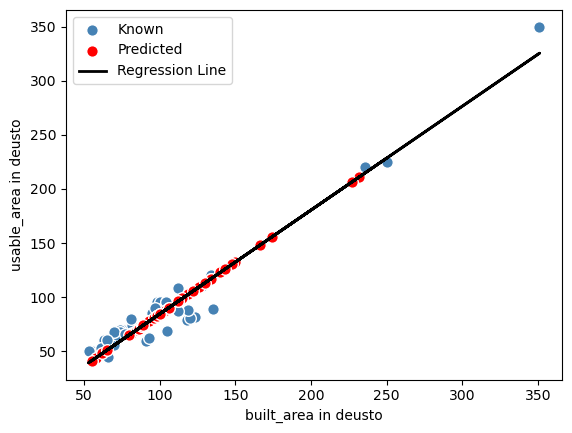

Predicted Values Result
Zone: deusto, Mean Built Area: 110.47826086956522, Mean Usable Area: 94.46481761762162, Mean Percentage Decrease Area: 14.49465544253061


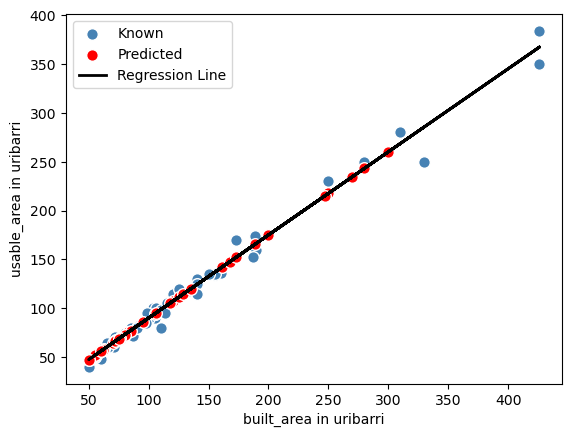

Predicted Values Result
Zone: uribarri, Mean Built Area: 127.79069767441861, Mean Usable Area: 113.54987260032993, Mean Percentage Decrease Area: 11.14386675497385


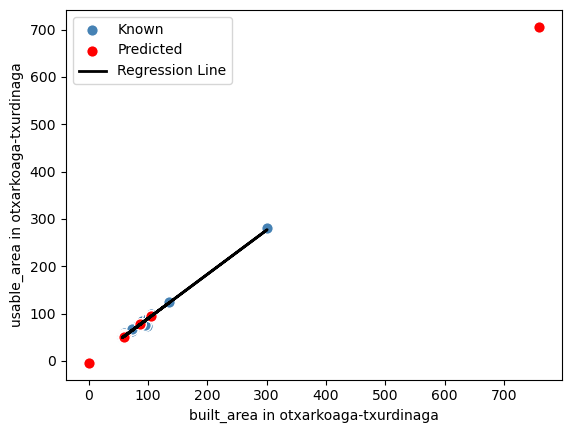

Predicted Values Result
Zone: otxarkoaga-txurdinaga, Mean Built Area: 144.22222222222223, Mean Usable Area: 130.80831394013458, Mean Percentage Decrease Area: 9.300860904375101


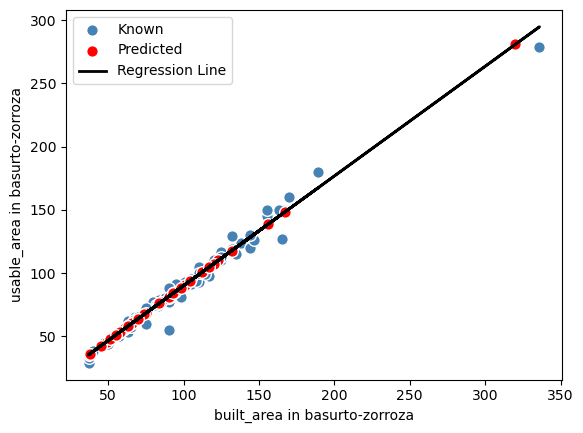

Predicted Values Result
Zone: basurto-zorroza, Mean Built Area: 88.475, Mean Usable Area: 80.03045876585304, Mean Percentage Decrease Area: 9.544550702624418


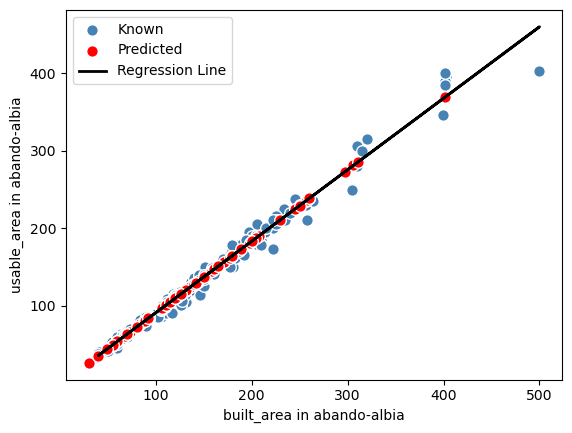

Predicted Values Result
Zone: abando-albia, Mean Built Area: 148.20253164556962, Mean Usable Area: 135.3079091144128, Mean Percentage Decrease Area: 8.700676289386642


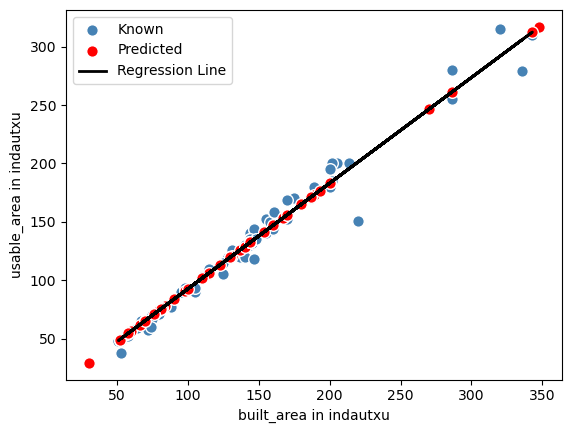

Predicted Values Result
Zone: indautxu, Mean Built Area: 132.61702127659575, Mean Usable Area: 122.11462041558521, Mean Percentage Decrease Area: 7.9193460687870285


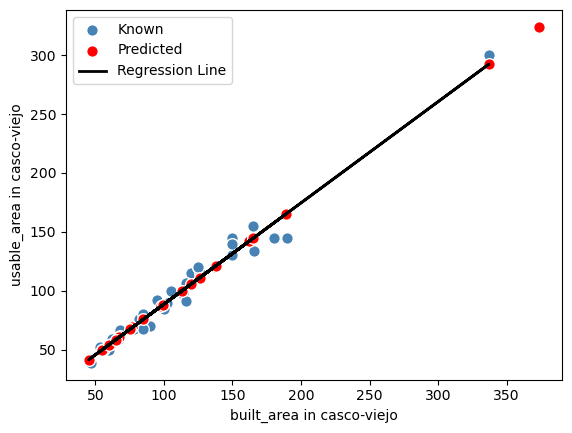

Predicted Values Result
Zone: casco-viejo, Mean Built Area: 122.375, Mean Usable Area: 107.98174889641471, Mean Percentage Decrease Area: 11.761594364523216


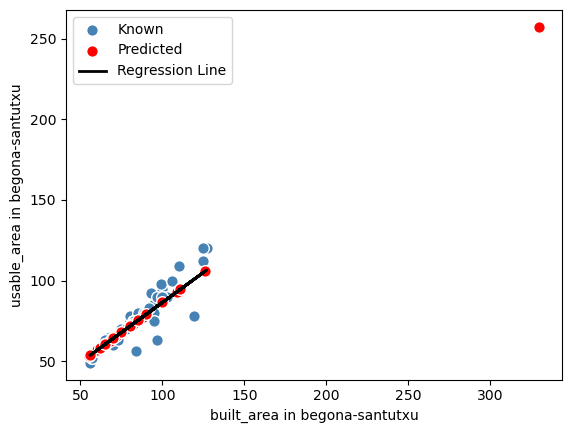

Predicted Values Result
Zone: begona-santutxu, Mean Built Area: 87.6, Mean Usable Area: 77.19376420199646, Mean Percentage Decrease Area: 11.879264609593077


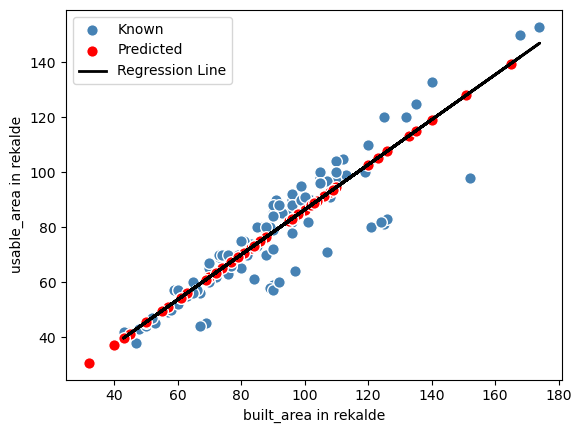

Predicted Values Result
Zone: rekalde, Mean Built Area: 94.0625, Mean Usable Area: 81.49278137785687, Mean Percentage Decrease Area: 13.363156010251831


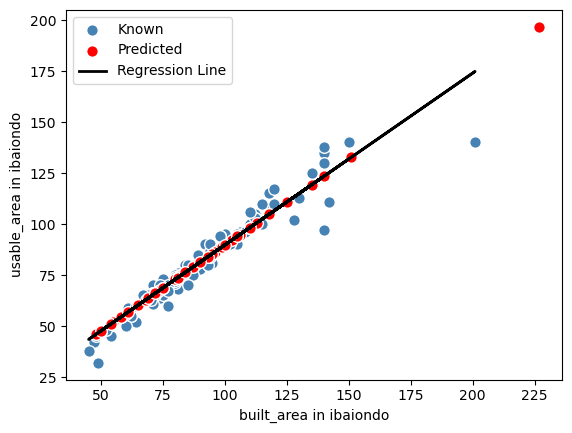

Predicted Values Result
Zone: ibaiondo, Mean Built Area: 91.49019607843137, Mean Usable Area: 82.60434935402984, Mean Percentage Decrease Area: 9.712348541459026


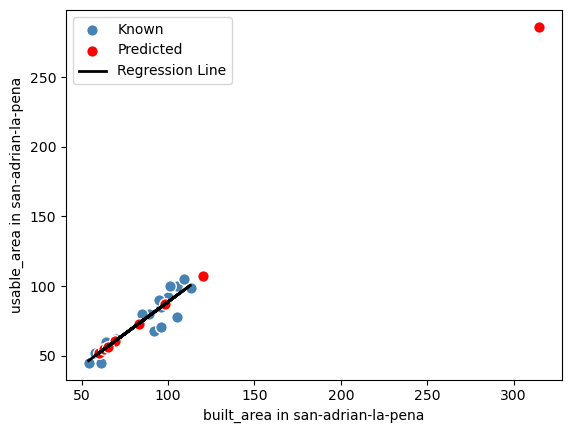

Predicted Values Result
Zone: san-adrian-la-pena, Mean Built Area: 109.125, Mean Usable Area: 97.1169448676131, Mean Percentage Decrease Area: 11.003945138498878


In [45]:
data_mod_ua_lr = data.copy()

# Loop through each unique zone
for zone_ua in data_mod_ua_lr['zone'].unique():
    
    # Select rows belonging to the current zone
    mask = data_mod_ua_lr['zone'] == zone_ua
    zone_data = data_mod_ua_lr.loc[mask]

    # Separate rows with and without usable_area values
    known = zone_data[zone_data['usable_area'].notnull()]
    unknown = zone_data[zone_data['usable_area'].isnull()]

    # Prepare data for regression
    X_train = known[['built_area']].values
    y_train = known['usable_area'].values

    # Train the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predict usable_area for rows where it's missing
    X_pred = unknown[['built_area']].values
    predicted_values = lin_reg.predict(X_pred)

    # Calculate the mean 'built_area' & 'usable_area' for the current zone and the percentage decrease between them for the newly predicted values
    mask_unknown = (data_mod_ua_lr['zone'] == zone_ua) & (data_mod_ua_lr['usable_area'].isnull())
    ba_mean = data_mod_ua_lr.loc[mask_unknown, 'built_area'].mean()
    ua_mean = predicted_values.mean()
    pda_mean = ((ba_mean - ua_mean) / ba_mean) * 100

    # Fill missing usable_area with predictions
    data_mod_ua_lr.loc[unknown.index, 'usable_area'] = predicted_values

    # Visualize the results
    plt.scatter(X_train, y_train, c='steelblue', edgecolor='white', s=70, label='Known')
    plt.scatter(X_pred, predicted_values, c='red', edgecolor='white', s=70, label='Predicted')
    plt.plot(X_train, lin_reg.predict(X_train), color='black', lw=2, label='Regression Line')
    plt.xlabel('built_area in ' + zone_ua)
    plt.ylabel('usable_area in ' + zone_ua)
    plt.legend()
    plt.show()

    print(f"Predicted Values Result\nZone: {zone_ua}, Mean Built Area: {ba_mean}, Mean Usable Area: {ua_mean}, Mean Percentage Decrease Area: {pda_mean}")

# We will use these predicted values for filling the null values in usable_area column since they seem to be more "accurate", or rather, stable, meaning the Percentage Decrease Area (PDA) is more consistent across zones.
data = data_mod_ua_lr.copy()

### IDK

In [46]:
# Check the amount of houses with exterior orientation
print(data['exterior'].value_counts())

# Print the urls of the houses with null orientation
print(data[data['exterior'].isnull()]["url"])

print(data[data["new"] == True]["exterior"].isnull().sum())


exterior
exterior    957
interior    127
Name: count, dtype: int64
10      https://www.idealista.com/inmueble/108574469/
14      https://www.idealista.com/inmueble/104105241/
15      https://www.idealista.com/inmueble/108376976/
16      https://www.idealista.com/inmueble/106596850/
24      https://www.idealista.com/inmueble/109237730/
28      https://www.idealista.com/inmueble/108746339/
36      https://www.idealista.com/inmueble/107151456/
37      https://www.idealista.com/inmueble/104175500/
38      https://www.idealista.com/inmueble/106596877/
39      https://www.idealista.com/inmueble/107151440/
56      https://www.idealista.com/inmueble/109337060/
59      https://www.idealista.com/inmueble/108748919/
60      https://www.idealista.com/inmueble/108748921/
66      https://www.idealista.com/inmueble/106517920/
76      https://www.idealista.com/inmueble/108396564/
82      https://www.idealista.com/inmueble/107910726/
83      https://www.idealista.com/inmueble/108520857/
84      https:/

In [47]:
# Check the amount of houses per condition
print(data['condition'].value_counts())

condition
Buen estado    813
A reformar     287
Name: count, dtype: int64


In [48]:
# Check the amount of heating 
print(data['heating'].value_counts())

# Check the amount of houses with missing value in year, and compare each case with the value of the "new" column. We want to see how many of them have "new" as True
heating_data = data[data['heating'].notnull()][['heating', 'new']]

# We check how many of them have "new" as True
print(heating_data['new'].value_counts())

data[data["new"] == True]["heating"].value_counts()


heating
Individual    656
Central       215
Name: count, dtype: int64
new
False    834
True      37
Name: count, dtype: int64


heating
Individual    26
Central       11
Name: count, dtype: int64

In [49]:
# Check the amount of houses with missing value in year, and compare each case with the value of the "new" column. We want to see how many of them have "new" as True
year_data = data[data['year'].isnull()][['year', 'new']]

# We check how many of them have "new" as True
print(year_data['new'].value_counts())

# Print the new column
print(data['new'].value_counts())

new
False    479
True     130
Name: count, dtype: int64
new
False    1100
True      130
Name: count, dtype: int64


"CONDITION" CLEANING

In [50]:
print(data.shape)
print("Numero Condition null: ", data['condition'].isnull().sum())


#Los 131 casos en los que "condition" es null porque la casa es NUEVA:
print("Numero Condition null y New True: ", data[(data['condition'].isnull()) & (data['new'] == True)].shape[0])

#Voy a confirmarlo a mano: 
print(data[data['condition'].isnull()]['url'])
#Efectivamente todas los valores de "condition" que son null, son casas nuevas. 

# Por lo que voy a rellenar esos 131 valores con de la columna "condition" con "Nuevo"
data.loc[data['condition'].isnull(), 'condition'] = 'Nuevo'


print(data.head())

(1230, 24)
Numero Condition null:  130
Numero Condition null y New True:  130
1       https://www.idealista.com/inmueble/106221410/
2       https://www.idealista.com/inmueble/107750109/
3       https://www.idealista.com/inmueble/106221526/
4       https://www.idealista.com/inmueble/108491309/
5       https://www.idealista.com/inmueble/108491397/
6       https://www.idealista.com/inmueble/108491389/
14      https://www.idealista.com/inmueble/104105241/
15      https://www.idealista.com/inmueble/108376976/
16      https://www.idealista.com/inmueble/106596850/
29      https://www.idealista.com/inmueble/106993005/
30      https://www.idealista.com/inmueble/106993032/
31      https://www.idealista.com/inmueble/106993141/
32      https://www.idealista.com/inmueble/106993139/
33      https://www.idealista.com/inmueble/106993140/
34      https://www.idealista.com/inmueble/106993143/
35      https://www.idealista.com/inmueble/106993138/
36      https://www.idealista.com/inmueble/107151456/
37  

"YEAR" CLEANING

In [51]:
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)

emissions_value      0.544715
consumption_value    0.542276
year                 0.495122
emissions_label      0.380488
consumption_label    0.356911
heating              0.291870
exterior             0.118699
floor                0.103252
url                  0.000000
balcony              0.000000
agency               0.000000
condition            0.000000
new                  0.000000
storage_room         0.000000
price                0.000000
garage               0.000000
elevator             0.000000
bathrooms            0.000000
bedrooms             0.000000
usable_area          0.000000
built_area           0.000000
neighborhood         0.000000
zone                 0.000000
description          0.000000
dtype: float64


In [52]:
pd.set_option('display.max_rows', None) # he puesto esto para que me meustre todas las filas


#hay 609 casas con valor "null" en year.
print(data[data["year"].isnull()].shape[0])

# ver si hay casos en los que Year es null y "New" es true (es decir, es obra nueva)
print(data[(data["year"].isnull()) & (data["new"]==True)].shape[0])

#Hay 130 casos en los que Year es null y es obra nueva (New==True)
#En estos casos vamos a poner el valor del año actual (2025)
data.loc[(data["year"].isnull()) & (data["new"]==True), "year"] = 2025


#En los 479 casos restantes que NO es OBRA NUEVA poner la MEDIANA de la zona (o hacer LINEAR REGRESSION)
# (esto tendré que probar y ver cual da mejores resultados.)


609
130


In [53]:
#print the url, zone and year of the houses with null year
print(data[data["year"].isnull()][["url", "zone", "year"]])

                                                url                   zone  \
7     https://www.idealista.com/inmueble/109013297/                 deusto   
8     https://www.idealista.com/inmueble/108626918/                 deusto   
9     https://www.idealista.com/inmueble/108471006/                 deusto   
10    https://www.idealista.com/inmueble/108574469/                 deusto   
12    https://www.idealista.com/inmueble/109408699/                 deusto   
17    https://www.idealista.com/inmueble/108298767/                 deusto   
19    https://www.idealista.com/inmueble/109215410/                 deusto   
24    https://www.idealista.com/inmueble/109237730/                 deusto   
25    https://www.idealista.com/inmueble/109191209/                 deusto   
26    https://www.idealista.com/inmueble/102494642/                 deusto   
47    https://www.idealista.com/inmueble/109384768/                 deusto   
58    https://www.idealista.com/inmueble/109218490/             

OPCION1: Mediana (lo hago separado para probarlo, luego lo juntare)

In [54]:
#print(data[data["year"].isnull()]["url"])


dataCp = data.copy()

#store in datacp2 the rows where year is NOT null.
dataCp2 = dataCp[dataCp["year"].notnull()]

#pasar las zonas unicas a un array y calcular las medianas para cada zona

zonas = dataCp2["zone"].unique().tolist()
medianas = []
medias = []
for i in range(len(zonas)):
    zona = zonas[i]
    mediana = statistics.median(dataCp2.loc[dataCp2["zone"]==zona, "year"])
    media = round(statistics.mean(dataCp2.loc[dataCp2["zone"]==zona, "year"]), 0)
    medianas.append(mediana)
    medias.append(media)

print("Zonas:",zonas)
print("Medianas: ", medianas)
print("Media: ", medias)

#Voy a sustituir los valores nulos de year por la mediana ya que es mas restistente a valores atipicos que la media.
#Pero en el caso particular de deusto voy a elegir el valor que me da la media ya que como podemos ver aqui muchas casas son de construccion nueva, 
#haciendo que la mediana de 2025, pero realmente no todas las casas son de ese año por eso creemos que en este caso es mejor usar el mean.

#añosDeusto = dataCp2.loc[dataCp2["zone"]=="deusto", "year"]
#print("Deusto: ", añosDeusto)


#Quiero ver cuanto varia de media los "year" de las casas respecto a la mediana calculada por zona
diferenciasMediana = []
diferencia_medias = []
for i in range(len(zonas)):
    zona = zonas[i]
    mediana = medianas[i]
    media = medias[i]
    añosZona = dataCp2.loc[dataCp2["zone"]==zona, "year"]
    suma_diferencias_mediana = sum([abs(año - mediana) for año in añosZona])
    suma_diferencias_media = sum([abs(año - media) for año in añosZona])

    diferencia_mediana = suma_diferencias_mediana / len(añosZona)
    diferencia_media = suma_diferencias_media / len(añosZona)

    diferenciasMediana.append(diferencia_mediana)
    diferencia_medias.append(diferencia_media)

print("Diferencias medias respecto a la mediana por zona: ", diferenciasMediana)

print("Diferencias medias respecto a la media por zona: ", diferencia_medias)

media_diferenciasMediana = sum(diferenciasMediana) / len(diferenciasMediana)
media_diferenciasMedia = sum(diferencia_medias) / len(diferencia_medias)

#es decir, hay un error de 25.48 años de media al usar la mediana para rellenar los valores nulos.
print("Media de las diferencias usando la mediana: ", media_diferenciasMediana)

#es decir, hay un error de 26.82 años de media al usar la media para rellenar los valores nulos.
print("Media de las diferencias usando la media: ", media_diferenciasMedia)


"""
for i in range(len(zonas)):
    if(zonas[i]=="deusto"):
        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medias[i]
    else:
        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medianas[i]


#comprobacion de que ya no hay ningun valor null en year
print(data[data["year"].isnull()][["url", "zone", "year"]])

#comprobacion del primer url que antes tenia null para ver que ha funcionado
print(data.loc[data["url"]=="https://www.idealista.com/inmueble/109013297/", "year"])
"""


Zonas: ['deusto', 'uribarri', 'otxarkoaga-txurdinaga', 'basurto-zorroza', 'abando-albia', 'indautxu', 'casco-viejo', 'begona-santutxu', 'rekalde', 'ibaiondo', 'san-adrian-la-pena']
Medianas:  [2025.0, 1965.0, 1996.0, 1970.0, 1940.0, 1958.0, 1899.0, 1973.5, 2002.0, 1950.0, 1987.0]
Media:  [2007.0, 1962.0, 1995.0, 1975.0, 1943.0, 1953.0, 1910.0, 1983.0, 1994.0, 1945.0, 1987.0]
Diferencias medias respecto a la mediana por zona:  [18.0, 18.228571428571428, 25.875, 28.68831168831169, 34.19548872180451, 11.95, 37.25, 17.195652173913043, 29.205128205128204, 37.30107526881721, 22.5]
Diferencias medias respecto a la media por zona:  [22.857142857142858, 18.742857142857144, 25.875, 29.4025974025974, 34.35338345864662, 13.4, 40.25, 20.152173913043477, 29.837606837606838, 37.74193548387097, 22.5]
Media de las diferencias usando la mediana:  25.48992977150419
Media de las diferencias usando la media:  26.828427008705933


'\nfor i in range(len(zonas)):\n    if(zonas[i]=="deusto"):\n        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medias[i]\n    else:\n        data.loc[(data["zone"]==zonas[i]) & (data["year"].isnull()),"year"] = medianas[i]\n\n\n#comprobacion de que ya no hay ningun valor null en year\nprint(data[data["year"].isnull()][["url", "zone", "year"]])\n\n#comprobacion del primer url que antes tenia null para ver que ha funcionado\nprint(data.loc[data["url"]=="https://www.idealista.com/inmueble/109013297/", "year"])\n'

In [55]:
null_percentage = data.isnull().mean().sort_values(ascending=False)
print(null_percentage)
data.head()

emissions_value      0.544715
consumption_value    0.542276
year                 0.389431
emissions_label      0.380488
consumption_label    0.356911
heating              0.291870
exterior             0.118699
floor                0.103252
url                  0.000000
balcony              0.000000
agency               0.000000
condition            0.000000
new                  0.000000
storage_room         0.000000
price                0.000000
garage               0.000000
elevator             0.000000
bathrooms            0.000000
bedrooms             0.000000
usable_area          0.000000
built_area           0.000000
neighborhood         0.000000
zone                 0.000000
description          0.000000
dtype: float64


,url,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,...,new,condition,year,heating,agency,consumption_value,consumption_label,emissions_value,emissions_label,description
0,https://www.idealista.com/inmueble/109356873/,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.000000,2,2,3.0,exterior,...,False,Buen estado,2025.0,Individual,ORDUNTE Inmobiliaria,23,A,4,A,"GASTOS DE GESTIÓN de 1,5 por ciento + IVA a ca..."
1,https://www.idealista.com/inmueble/106221410/,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,67.104025,2,2,1.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
2,https://www.idealista.com/inmueble/107750109/,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,44.045770,1,1,4.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
3,https://www.idealista.com/inmueble/106221526/,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,88.240759,3,2,1.0,exterior,...,True,Nuevo,2025.0,Central,LOIOLA GESTIÓN INMOBILIARIA,NaN,A,NaN,A,La nueva promoción de Loiola se compone de 42 ...
4,https://www.idealista.com/inmueble/108491309/,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,47.888812,1,1,1.0,exterior,...,True,Nuevo,2025.0,NaN,Loiola,NaN,A,NaN,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac..."


OPCION2: LINEAR REGRESSION

MODELO GLOBAL (NO POR ZONAS), PARA MISSING VALUES DE YEAR
El modelo no esta del todo mal:

0.53 de varianza explicada
18.03 años de error en promedio (mejor que con la mediana)
Si revisamos los plot podemos ver que hay:

- "Heteroscedasticity" (el lmodelo predice mejor los años mas actuales) (no se arregla ni con log ni con sqrt)




RMSE: 25.67
R²: 0.58
MAE²: 18.03


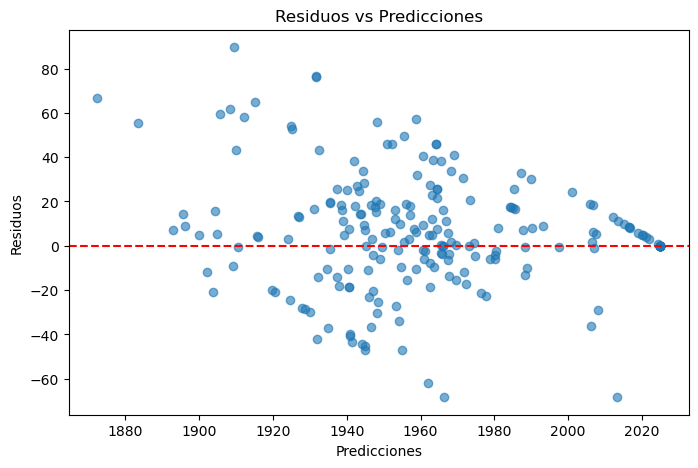

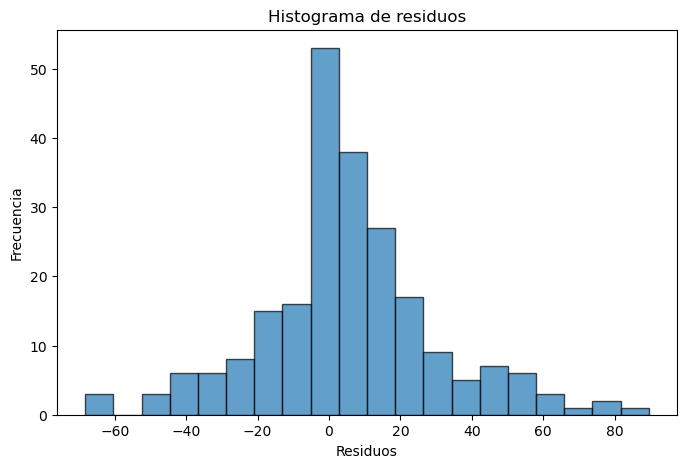

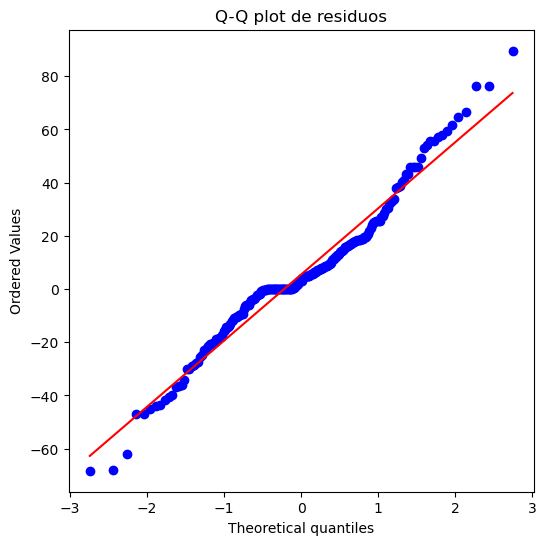

In [56]:
#Regresion prueba 2



from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats


# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------
# Supongamos que tu dataframe se llama `data`
# Eliminamos columnas que tienen valores nulos o inncesearias (como url, agency y description)
data_clean = dataCp.drop(columns=['url', 'agency','description','floor','exterior', 'heating','consumption_label','emissions_label','consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 'Nuevo': 1, 'Buen estado': 0})

# Para 'condition', si hay más de 2 categorías, lo convertimos a One-Hot
# Si solo dos categorías (Nuevo/Buen estado) ya lo manejamos arriba

# Columnas categóricas con múltiples categorías
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)



# Eliminar filas con NA
data_encoded = data_encoded.dropna()



def regression_lasso(data, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()

    # Ajustar el scaler solo con X_train
    X_train_scaled = scaler.fit_transform(X_train)

    # Transformar X_test usando el mismo scaler (no hacer fit otra vez)
    X_test_scaled = scaler.transform(X_test)
    # Lasso con cross-validation para elegir el alpha óptimo
    lasso = LassoCV(cv=5, max_iter=10000,random_state=42).fit(X_train_scaled, y_train)


    # Coeficientes
    coef = pd.Series(lasso.coef_, index=X.columns)
    #print("Coeficientes Lasso:\n", coef)
    

    # Features seleccionadas
    selected_features = coef[coef != 0].index.tolist()
    #print("Features seleccionadas:", selected_features)


    # Predicciones en el set de test
    y_pred = lasso.predict(X_test_scaled)

    #EL MODELO PREDICE YEARS QUE QUE SE PASAN DE 2025 ES DECIR AÑOS FUTUROS.
    #Con esto lo ajustamos para que siempre este entre el año mas pequeño y mas grande del dataset
    y_pred  = np.clip(y_pred, min(data["year"]), max(data["year"]))


    # Métricas
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)



    print(f"RMSE: {rmse:.2f}")

    #R² = 0.53 lo que indica que el modelo explica aproximadamente el 53% de la variabilidad en la variable dependiente "year".
    print(f"R²: {r2:.2f}")

    #MAE = 19.5 lo que significa que, en promedio, las predicciones del modelo se desvían del valor real de "year" en aproximadamente 19.5 años.
    print(f"MAE²: {mae:.2f}")

    feature_cols = X.columns
    


    return y_test, y_pred, feature_cols, selected_features, lasso, scaler


# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']


y_test, y_pred, feature_cols, selected_features, lasso, scaler= regression_lasso(data, X, y)

global_scaler = scaler #lo guardamos para aplicarlo mas tarde a las zonas que no han funcionado bien con los modelos Lasso y Ransac por zona.
global_lasso = lasso #lo guardamos para aplicarlo mas tarde a las zonas que no han funcionado bien con los modelos Lasso y Ransac por zona.
feature_cols_global = feature_cols

residuals = y_test - y_pred

# a) Residual plot (linealidad y homocedasticidad) --> OJJOJ: se aprecia cierta heterocedasticidad (el modelo predice mejor los años mas recientes/futuros)
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.show()

# b) Histograma de residuos (normalidad) --> bien porque los residuos siguen mas o menos una distribucion normal
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos")
plt.show()

# c) Q-Q plot de residuos (normalidad) 
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos")
plt.show()






Probamos con Ransac para el modelo global y da peor, asique nos quedamos con el anterior. 

RMSE: 27.87
R²: 0.51
MAE: 19.71


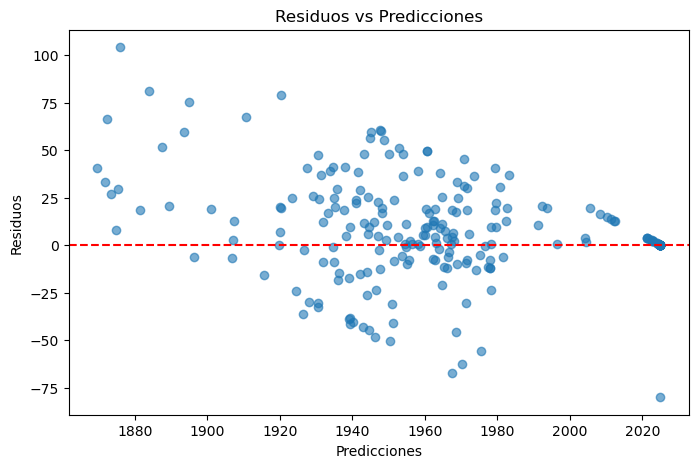

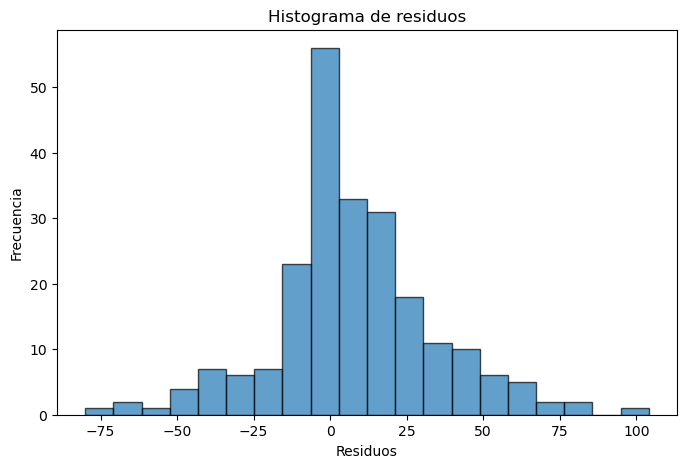

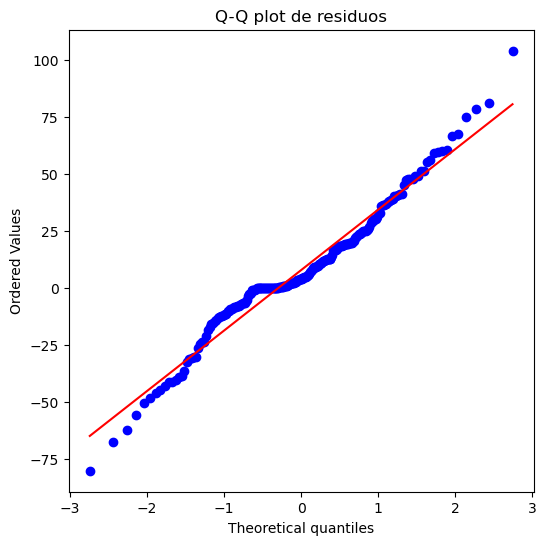

In [57]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import scipy.stats as stats

# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------


def regression_ransac(data, X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ---------------------------
    # 2️⃣ Selección de features con Lasso
    # ---------------------------
    lasso = LassoCV(cv=5, random_state=42, max_iter=3000).fit(X_train_scaled, y_train)
    coef = pd.Series(lasso.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()
    #print("Features seleccionadas por Lasso:", selected_features)
    


    # Reducir matrices a las features seleccionadas
    X_train_sel = X_train_scaled[:, [X.columns.get_loc(f) for f in selected_features]]
    X_test_sel  = X_test_scaled[:, [X.columns.get_loc(f) for f in selected_features]]

    # ---------------------------
    # 3️⃣ Ajuste del modelo RANSAC sobre las features seleccionadas
    # ---------------------------
    ransac = RANSACRegressor(LinearRegression(), min_samples=0.5, residual_threshold=5.0, random_state=42)

    ransac.fit(X_train_sel, y_train)

    feature_cols = X.columns

    # Predicciones
    y_pred = ransac.predict(X_test_sel)
    y_pred = np.clip(y_pred, min(data["year"]), max(data["year"]))  # limitar dentro del rango real

    # ---------------------------
    # 4️⃣ Métricas
    # ---------------------------
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAE: {mae:.2f}")

    # ---------------------------
    # 5️⃣ Análisis de residuos
    # ---------------------------
    return y_test, y_pred, feature_cols, selected_features, ransac, scaler





# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

y_test, y_pred, feature_cols,selected_features, ransac, scaler = regression_ransac(data,X,y)
residuals = y_test - y_pred


plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos")
plt.show()
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos")
plt.show()


In [58]:
print(data[data["year"].isnull()].shape[0])

for zona in data['zone'].unique():
    count_nulls = data[(data['zone'] == zona) & (data['year'].isnull())].shape[0]
    print(f"Zona: {zona}, Filas con year null: {count_nulls}")


479
Zona: deusto, Filas con year null: 27
Zona: uribarri, Filas con year null: 43
Zona: otxarkoaga-txurdinaga, Filas con year null: 10
Zona: basurto-zorroza, Filas con year null: 50
Zona: abando-albia, Filas con year null: 104
Zona: indautxu, Filas con year null: 56
Zona: casco-viejo, Filas con year null: 33
Zona: begona-santutxu, Filas con year null: 30
Zona: rekalde, Filas con year null: 50
Zona: ibaiondo, Filas con year null: 63
Zona: san-adrian-la-pena, Filas con year null: 13


Vamos a probar a aplicar Lasso y Lasso+Ransac por zonas para ver si da mejor resultado

In [59]:

zonas = data_clean["zone"].unique().tolist()

print(zonas)

data_encode_list = []

for zone in zonas:
    # Filtramos solo la zona
    df = data_clean.loc[data_clean["zone"] == zone].copy()
    
    # Eliminamos la columna zone
    df.drop("zone", axis=1, inplace=True)
    
    # Creamos dummies solo de los valores presentes en esa zona
    df = pd.get_dummies(df, columns=['neighborhood', 'condition'], drop_first=True)
    
    # Eliminamos filas con NA
    df.dropna(inplace=True)
    
    # Guardamos el dataframe transformado en la lista
    data_encode_list.append(df)

['deusto', 'uribarri', 'otxarkoaga-txurdinaga', 'basurto-zorroza', 'abando-albia', 'indautxu', 'casco-viejo', 'begona-santutxu', 'rekalde', 'ibaiondo', 'san-adrian-la-pena']


In [60]:




print("....................LASSO (per zones)..........................")


#ahora aplicamos el linear regression a cada dataframe por zona
for i in range(len(data_encode_list)):

    if(len(data_encode_list[i]>=10)):
        print(f"\n{'='*60}")
        print(f"ZONA: {zonas[i]}")
        print(f"Número de muestras: {len(data_encode_list[i])}\n")
        #print(f"{'='*60}")
        
        # Separar variables dependiente e independiente
        data_encoded = data_encode_list[i]
        X = data_encoded.drop(columns=['year'])
        y = data_encoded['year']

        y_test, y_pred, feature_cols, selected_features, lasso, scaler = regression_lasso(data_encode_list[i],X, y)

        if(i == 5): #para ver que pasa con idautxu(ya que en los resultados vemos que especialmente esta zona tienen un R2 muy bajo (negativo))
            d = {'real': y_test, 'pred': y_pred}
            df = pd.DataFrame(data=d)
            print("RealVspred", df)

#a rekalde, begona-santutxu, basurto zorrotza, otxarkoaga txurdinaga y deusto este modelo de Lasso por zona mejora los resultados del modelo global,



"""
============================================================
ZONA: deusto ✅
Número de muestras: 63

RMSE: 18.89
R²: 0.60
MAE²: 12.31


============================================================
ZONA: otxarkoaga-txurdinaga✅
Número de muestras: 24

RMSE: 15.14
R²: 0.68
MAE²: 9.93

============================================================
ZONA: basurto-zorroza✅
Número de muestras: 77

RMSE: 25.86
R²: 0.53
MAE²: 17.33



============================================================
ZONA: begona-santutxu ✅
Número de muestras: 46

RMSE: 13.28
R²: 0.74
MAE²: 7.45

============================================================
ZONA: rekalde ✅
Número de muestras: 117

RMSE: 13.38
R²: 0.83
MAE²: 9.00


"""



#En Indautxu por ejemplo el R2 da muy bajo (negativo) pero MAE bueno. Vamos a ver reales vs predicciones para ver que pasa.


"""


============================================================
ZONA: indautxu
Número de muestras: 80

RMSE: 17.68
R²: -0.47
MAE²: 12.58

"""


# Analizamos los resultados de test vs predicciones y efectivamente vemos que esto se da porque en general 
#los valores predichos se acercan bastante a los reales (MAE aceptable) pero hay casos (los marcados) que tienen un error muy grande (40-50 años) (R2 negativo)

"""real         pred
749  1934.0  1932.764010
701  1957.0  1956.684259
735  1955.0  1963.584171
753  1935.0  1952.744101
728  1995.0  1954.557577 -----------
745  1969.0  1961.096719
714  1935.0  1965.100028 ----------
841  1968.0  1951.438781
706  1948.0  1944.635199
719  1963.0  1957.881172
786  1945.0  1952.740971
759  1959.0  1957.810538
838  1965.0  1945.305782
762  1990.0  1940.889240 ------------
839  1957.0  1951.856720
780  1958.0  1964.257885
848  1965.0  1961.096719
822  1966.0  1953.055704
802  1959.0  1971.776771
773  1970.0  1945.305782
713  1949.0  1965.595778
827  1958.0  1961.096719
707  1945.0  1948.410533
783  1955.0  1950.950347
"""

# en el resto como podemos ver el R2 es bajo y el MAE es alto, ya que pasa lo mismo que con Indautxu: 
# los valores predichos se acercan astante a los reales (MAE aceptable) pero hay casos que tienen un error muy grande (R2 )

"""
============================================================
ZONA: abando-albia
Número de muestras: 133

RMSE: 32.24
R²: 0.29
MAE²: 27.19



============================================================
ZONA: casco-viejo
Número de muestras: 28

RMSE: 57.15
R²: 0.02
MAE²: 41.71

============================================================
ZONA: ibaiondo
Número de muestras: 93

RMSE: 38.47
R²: 0.25
MAE²: 29.96


============================================================
ZONA: uribarri
Número de muestras: 70

RMSE: 23.38
R²: 0.12
MAE²: 18.42

============================================================
ZONA: san-adrian-la-pena
Número de muestras: 20

RMSE: 20.17
R²: 0.15
MAE²: 16.31
"""

print("....................LASSO+RANSAC (per zones)..........................")
                                        

#PROBAMOS CON RANSAC, de nuevo por zona (incluyendo las que daban buen resultado con Lasso para ver si mejora aun mas):     
for i in range(len(data_encode_list)):

    if(len(data_encode_list[i])>=10):
        print(f"\n{'='*60}")
        print(f"ZONA: {zonas[i]}")
        print(f"Número de muestras: {len(data_encode_list[i])}\n")
        #print(f"{'='*60}")
        
        # Separar variables dependiente e independiente
        data_encoded = data_encode_list[i]
        X = data_encoded.drop(columns=['year'])
        y = data_encoded['year']

        y_test, y_pred, feature_cols,selected_features, ransac, scaler = regression_ransac(data_encode_list[i],X, y)




#Vemos como con Ransac algunas de las predicciones que ya eran buenas con Lasso (por zonas) han mejorado (✅✅✅).
#Otras predicciones que con Lasso (por zonas) eran malas tambien han mejorado (✅).
#En otros casos las predicciones que con Lasso (por zonas) eran buenas han empeorado (❌❌❌).
#Y otras zonas siguen sin dar buenos resultados incluso con Ransac (❌).


"""
============================================================
ZONA: deusto ✅✅✅
Número de muestras: 63

RMSE: 19.56
R²: 0.57
MAE: 9.73

============================================================
ZONA: uribarri ❌
Número de muestras: 70

RMSE: 22.98
R²: 0.15
MAE: 17.88

============================================================
ZONA: otxarkoaga-txurdinaga❌❌❌
Número de muestras: 24

RMSE: 17.17
R²: 0.59
MAE: 10.79

============================================================
ZONA: basurto-zorroza ✅✅✅
Número de muestras: 77

RMSE: 21.32
R²: 0.68
MAE: 14.95

============================================================
ZONA: abando-albia❌
Número de muestras: 133

RMSE: 37.80
R²: 0.03
MAE: 28.89

============================================================
ZONA: indautxu ❌
Número de muestras: 80

RMSE: 16.49
R²: -0.28
MAE: 12.75

============================================================
ZONA: casco-viejo ❌
Número de muestras: 28

RMSE: 58.21
R²: -0.02
MAE: 42.21

============================================================
ZONA: begona-santutxu❌❌❌
Número de muestras: 46

RMSE: 15.82
R²: 0.63
MAE: 8.70

============================================================
ZONA: rekalde ✅✅✅
Número de muestras: 117

RMSE: 13.73
R²: 0.82
MAE: 7.73

============================================================
ZONA: ibaiondo ❌
Número de muestras: 93

RMSE: 41.19
R²: 0.14
MAE: 30.10

============================================================
ZONA: san-adrian-la-pena ✅
Número de muestras: 20

RMSE: 8.79
R²: 0.84
MAE: 5.04
"""

#Por lo tanto hasta aqui aplicariamos:
# el modelo con Ransac para rellenar los valores nulos de year en: deusto, basurto-zorroza, rekalde y san-adrian-la-pena. (lo aplicaremos en el codigo de arriba)
# el modelo con Lasso para rellenar los valores nulos de year en: otxarkoaga-txurdinaga y begona-santutxu. (lo aplicaremos en el codigo de arriba)
# el modelo global para rellenar los valores nulos de year en: indautxu, abando-albia, casco viejo, ibaiondo y uribarri. (lo haremos a continuacion)






....................LASSO (per zones)..........................

ZONA: deusto
Número de muestras: 63

RMSE: 18.86
R²: 0.60
MAE²: 12.31

ZONA: uribarri
Número de muestras: 70

RMSE: 23.38
R²: 0.12
MAE²: 18.42

ZONA: otxarkoaga-txurdinaga
Número de muestras: 24

RMSE: 15.14
R²: 0.68
MAE²: 9.93

ZONA: basurto-zorroza
Número de muestras: 77

RMSE: 25.86
R²: 0.53
MAE²: 17.33

ZONA: abando-albia
Número de muestras: 133

RMSE: 32.25
R²: 0.29
MAE²: 27.19

ZONA: indautxu
Número de muestras: 80

RMSE: 17.68
R²: -0.47
MAE²: 12.58
RealVspred        real         pred
749  1934.0  1932.763156
701  1957.0  1956.681294
735  1955.0  1963.583357
753  1935.0  1952.744760
728  1995.0  1954.554791
745  1969.0  1961.096381
714  1935.0  1965.097780
841  1968.0  1951.442897
706  1948.0  1944.636447
719  1963.0  1957.879197
786  1945.0  1952.741980
759  1959.0  1957.808775
838  1965.0  1945.304520
762  1990.0  1940.889378
839  1957.0  1951.856342
780  1958.0  1964.256434
848  1965.0  1961.096381
822  1966.0  1

'\n============================================================\nZONA: deusto ✅✅✅\nNúmero de muestras: 63\n\nRMSE: 19.56\nR²: 0.57\nMAE: 9.73\n\n============================================================\nZONA: uribarri ❌\nNúmero de muestras: 70\n\nRMSE: 22.98\nR²: 0.15\nMAE: 17.88\n\n============================================================\nZONA: otxarkoaga-txurdinaga❌❌❌\nNúmero de muestras: 24\n\nRMSE: 17.17\nR²: 0.59\nMAE: 10.79\n\n============================================================\nZONA: basurto-zorroza ✅✅✅\nNúmero de muestras: 77\n\nRMSE: 21.32\nR²: 0.68\nMAE: 14.95\n\n============================================================\nZONA: abando-albia❌\nNúmero de muestras: 133\n\nRMSE: 37.80\nR²: 0.03\nMAE: 28.89\n\n============================================================\nZONA: indautxu ❌\nNúmero de muestras: 80\n\nRMSE: 16.49\nR²: -0.28\nMAE: 12.75\n\n============================================================\nZONA: casco-viejo ❌\nNúmero de muestras: 28\n\nRMS

Como hemos visto, utilizando por zona (menos en los casos en los que daba mejor resultado con el modelo global) con Lasso (para elegir solo las variables significativas) y Ransac (para consguir robusted contra outliers) daban mejores resultados que el modelo global que utilizaba simeplemente Lasso. 
Pero vamos a intentar mejorarlo aun mas, para intentar conseguir el "year" mas preciso posible utilizando 2 modelos diferentes: 
- 1.RandomForest Regressor (ensemble method), esperemos que de mejores resultados porque...
   - Es un enssemble method. 
   - Robusto a outliers y features no signifcativos (no hace falta usar Ransac)
   - Interacciones entre variables automaticas 
   - Puede trabajar con relaciones no lineales (polinomicas...)
- 2.Catboost Regressor  
   - Es como un RandomForest pero cada arbol corrige errores del anterior
   - Puede trabajar con categorias (nosotros hemos seguido utilizando dummy variables ya que en este caso particular da mejores resultados y es más rápido)

Ambos se basan en arboles







En el codigo de arriba he estado asignando y cambiando el valor a data_encoded asique porsiacaso y para que no haya errores vuelvo a poner este trozo de codigo aqui definiendo data_encoded (ya lo cambiare mas adelante)

In [61]:
data_clean = dataCp.drop(columns=['url', 'agency','description','floor','exterior', 'heating','consumption_label','emissions_label','consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 'Nuevo': 1, 'Buen estado': 0})

# Para 'condition', si hay más de 2 categorías, lo convertimos a One-Hot
# Si solo dos categorías (Nuevo/Buen estado) ya lo manejamos arriba

# Columnas categóricas con múltiples categorías
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)



# Eliminar filas con NA
data_encoded = data_encoded.dropna()


zonas = data_clean["zone"].unique().tolist()

print(zonas)

data_encode_list = []

for zone in zonas:
    # Filtramos solo la zona
    df = data_clean.loc[data_clean["zone"] == zone].copy()
    
    # Eliminamos la columna zone
    df.drop("zone", axis=1, inplace=True)
    
    # Creamos dummies solo de los valores presentes en esa zona
    df = pd.get_dummies(df, columns=['neighborhood', 'condition'], drop_first=True)
    
    # Eliminamos filas con NA
    df.dropna(inplace=True)
    
    # Guardamos el dataframe transformado en la lista
    data_encode_list.append(df)

['deusto', 'uribarri', 'otxarkoaga-txurdinaga', 'basurto-zorroza', 'abando-albia', 'indautxu', 'casco-viejo', 'begona-santutxu', 'rekalde', 'ibaiondo', 'san-adrian-la-pena']


Catboost

In [62]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np

# MODELO CATBOOST
def regression_catboost(data, X, y):


    # Dividir train-test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo CatBoost
    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        loss_function='MAE',
        verbose=0
    )


    # Entrenar
    model.fit(X_train, y_train)

    # Predicción test
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, min(data["year"]), max(data["year"]))  # limitar dentro del rango real

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    return y_test, y_pred, X.columns, model


ModuleNotFoundError: No module named 'catboost'

Global evaluation:
- Como podemos ver usando catboost regression para todos los datos da un resultado mejor que el Global anterior con Lasso o Ransac. 

In [ ]:
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

y_test, y_pred, feature_cols, model_cat = regression_catboost(data_encoded,X,y)

RMSE: 22.82
R²: 0.67
MAE: 14.98


Evaluation por zonas
- Como podemos ver dan unos resultados mejores que con Lasso y/o Ransac

In [ ]:
for i in range(len(data_encode_list)):

    if len(data_encode_list[i]) >= 10:

        print(f"\n{'='*60}")
        print(f"ZONA: {zonas[i]}")
        print(f"Nº muestras: {len(data_encode_list[i])}")

        data_zone = data_encode_list[i]

        X = data_zone.drop(columns=['year'])
        y = data_zone['year']

        # ENTRENAR CATBOOST
        y_test, y_pred, feature_cols, model_cat = regression_catboost(data_zone, X, y)




ZONA: deusto
Nº muestras: 63
RMSE: 10.34
R²: 0.84
MAE: 6.14

ZONA: uribarri
Nº muestras: 70
RMSE: 18.79
R²: 0.54
MAE: 13.66

ZONA: otxarkoaga-txurdinaga
Nº muestras: 24
RMSE: 11.74
R²: 0.82
MAE: 8.60

ZONA: basurto-zorroza
Nº muestras: 77
RMSE: 19.33
R²: 0.69
MAE: 14.76

ZONA: abando-albia
Nº muestras: 133
RMSE: 32.97
R²: 0.28
MAE: 24.94

ZONA: indautxu
Nº muestras: 80
RMSE: 16.35
R²: 0.07
MAE: 10.61

ZONA: casco-viejo
Nº muestras: 28
RMSE: 75.16
R²: -0.21
MAE: 61.95

ZONA: begona-santutxu
Nº muestras: 46
RMSE: 9.25
R²: 0.87
MAE: 4.16

ZONA: rekalde
Nº muestras: 117
RMSE: 11.83
R²: 0.88
MAE: 6.75

ZONA: ibaiondo
Nº muestras: 93
RMSE: 41.03
R²: -0.05
MAE: 30.59

ZONA: san-adrian-la-pena
Nº muestras: 20
RMSE: 6.53
R²: 0.94
MAE: 4.21


RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def regression_rf(data, X, y):


    # Train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo RF
    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=4,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Predicción
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, min(data["year"]), max(data["year"]))  # limitar dentro del rango real

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    return y_test, y_pred, X.columns, model, scaler


Global evaluation:
- Como podemos ver usando Random Forest regression para todos los datos da un resultado incluso un poco mejor que el de catboost

In [ ]:
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

y_test, y_pred, feature_cols, model_rf, scaler = regression_rf(data_encoded, X, y)


RMSE: 22.94
R²: 0.66
MAE: 14.69


Evaluation por zonas: 
- Como podemos ver en algunos casos mejor incluso el resultado de Catboost. (en los casos de: deusto, otxarkoaga-txurdinaga, basurto-zorroza, rekalde y san-adrian-la-pena)


ZONA: deusto
Nº muestras: 63
RMSE: 10.82
R²: 0.83
MAE: 5.55

ZONA: uribarri
Nº muestras: 70
RMSE: 20.11
R²: 0.47
MAE: 15.23

ZONA: otxarkoaga-txurdinaga
Nº muestras: 24
RMSE: 8.41
R²: 0.91
MAE: 7.03

ZONA: basurto-zorroza
Nº muestras: 77
RMSE: 17.50
R²: 0.74
MAE: 11.31

ZONA: abando-albia
Nº muestras: 133
RMSE: 30.53
R²: 0.38
MAE: 23.23

ZONA: indautxu
Nº muestras: 80
RMSE: 18.83
R²: -0.23
MAE: 12.33

ZONA: casco-viejo
Nº muestras: 28
RMSE: 73.35
R²: -0.15
MAE: 53.15

ZONA: begona-santutxu
Nº muestras: 46
RMSE: 10.01
R²: 0.85
MAE: 4.88

ZONA: rekalde
Nº muestras: 117
RMSE: 11.85
R²: 0.88
MAE: 6.67

ZONA: ibaiondo
Nº muestras: 93
RMSE: 43.63
R²: -0.18
MAE: 31.37

ZONA: san-adrian-la-pena
Nº muestras: 20
RMSE: 5.61
R²: 0.96
MAE: 3.93
RMSE: 30.53
R²: 0.38
MAE: 23.23


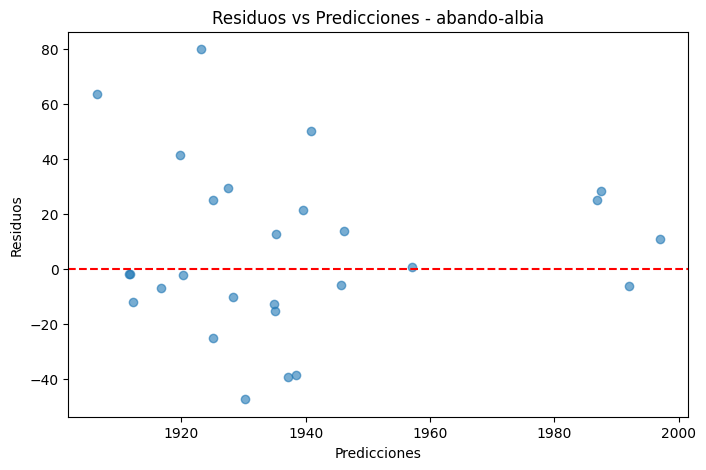

RMSE: 73.35
R²: -0.15
MAE: 53.15


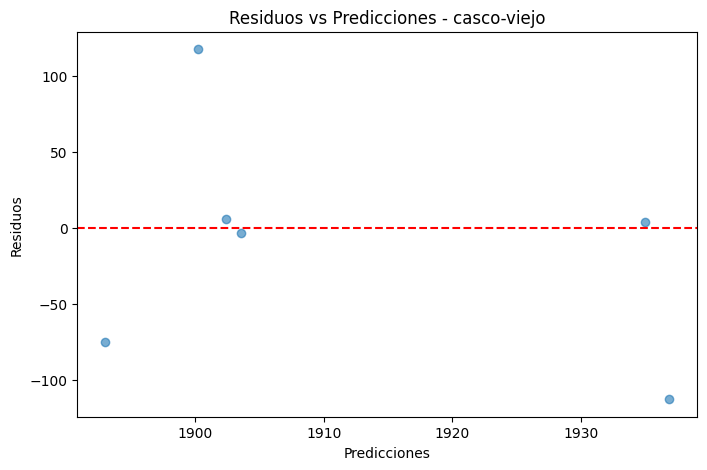

RMSE: 43.63
R²: -0.18
MAE: 31.37


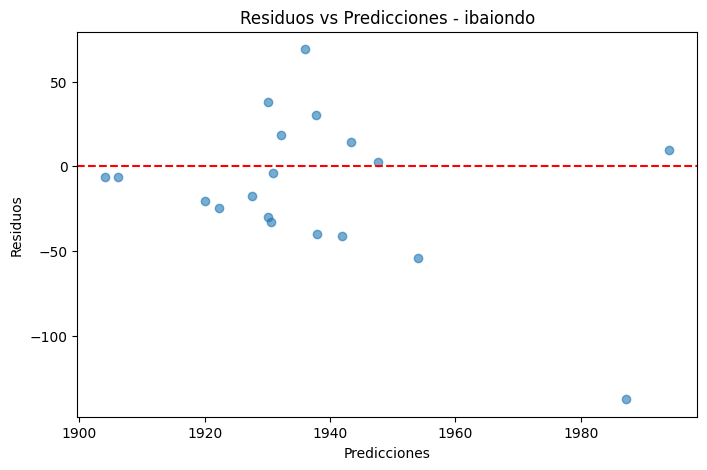

RMSE: 10.01
R²: 0.85
MAE: 4.88


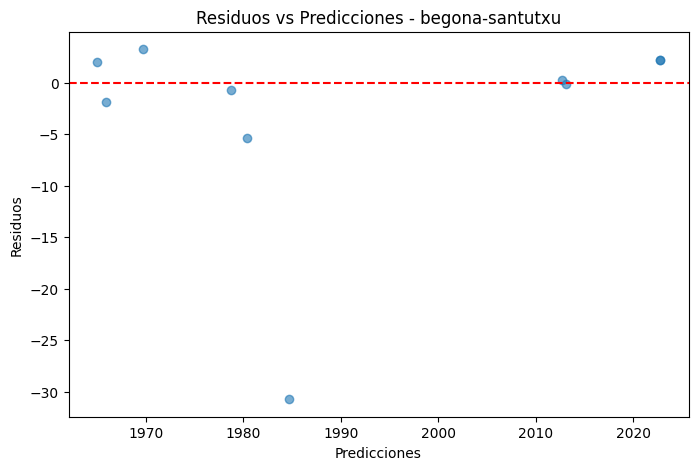

RMSE: 17.50
R²: 0.74
MAE: 11.31


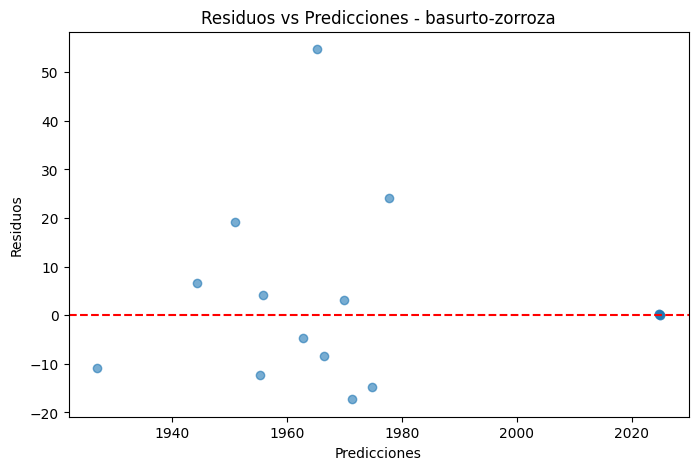

In [ ]:
for i in range(len(data_encode_list)):

    if len(data_encode_list[i]) >= 10:

        print(f"\n{'='*60}")
        print(f"ZONA: {zonas[i]}")
        print(f"Nº muestras: {len(data_encode_list[i])}")

        data_zone = data_encode_list[i]

        X = data_zone.drop(columns=['year'])
        y = data_zone['year']

        # ENTRENAR RF
        y_test, y_pred, feature_cols, model_rf, scaler = regression_rf(data_zone, X, y)


#printeame un plot con los residuos de abando-albia, casco-viejo y ibariondo usando regression_rf 
zones_to_plot = ['abando-albia', 'casco-viejo', 'ibaiondo', 'begona-santutxu', 'basurto-zorroza']
for zone in zones_to_plot:
    data_zone = data_encode_list[zonas.index(zone)]

    X = data_zone.drop(columns=['year'])
    y = data_zone['year']

    y_test, y_pred, feature_cols, model_rf, scaler = regression_rf(data_zone, X, y)

    residuals = y_test - y_pred

    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos")
    plt.title(f"Residuos vs Predicciones - {zone}")
    plt.show()



Vamos a reemplazar los valores de la columna year con los modelos que den mejores resultados: 
- Con RandomForestRegressor por zona:deusto, otxarkoaga-txurdinaga, basurto-zorroza, rekalde y san-adrian-la-pena
- Con Catboost por zona: uribarri, indautxu y begona-santutxu
- Con RandomForest global (aplicado a todos los datos): abando-albia, casco-viejo e ibaiondo.

In [ ]:




rf_zone_list = ["deusto","otxarkoaga-txurdinaga","basurto-zorroza","rekalde","san-adrian-la-pena"]
cb_list = ["uribarri", "indautxu", "begona-santutxu"]
rf_global_list = ["abando-albia", "casco-viejo", "ibaiondo"]

   

for zone in zonas:

    # Filtramos solo la zona
    df_zone = data_clean.loc[(data_clean["zone"] == zone)].copy()
        
    # Eliminamos la columna zone
    df_zone.drop("zone", axis=1, inplace=True)
        
    # Creamos dummies solo de los valores presentes en esa zona
    df_zone = pd.get_dummies(df_zone, columns=['neighborhood', 'condition'], drop_first=True)
        


    df_train = df_zone.dropna(subset=['year']).copy()

    df_nulls = df_zone[df_zone["year"].isnull()].copy()

    X = df_train.drop(columns=['year'])
    y = df_train['year']

    # Reindexar df_nulls para que tenga las mismas columnas
    df_nulls = df_nulls.reindex(columns=X.columns, fill_value=0)
    if (not df_nulls.empty):
        if(zone in rf_zone_list):             


            model_rf = RandomForestRegressor(
                n_estimators=500,
                max_depth=None,
                min_samples_split=4,
                random_state=42
            )

            model_rf.fit(X, y)

            # PREDECIR
            y_pred_nulls = model_rf.predict(df_nulls)
            y_pred_nulls = np.clip(y_pred_nulls, min(df_train["year"]), max(df_train["year"]))  # limitar dentro del rango real

        
        elif(zone in cb_list):

            # Modelo CatBoost
            model_cb = CatBoostRegressor(
                iterations=800,
                learning_rate=0.05,
                depth=8,
                loss_function='MAE',
                verbose=0
            )

            # Entrenar
            model_cb.fit(X, y)

            # Predicción test
            y_pred_nulls = model_cb.predict(df_nulls)
            y_pred_nulls = np.clip(y_pred_nulls, min(df_train["year"]), max(df_train["year"]))  # limitar dentro del rango real


        elif(zone in rf_global_list):

            df_global = data_clean.copy()
            df_global = pd.get_dummies(df_global, columns=['neighborhood', 'condition'], drop_first=True)
            df_global = df_global.drop("zone", axis=1)

            df_train = df_global.dropna(subset=['year']).copy()
            df_nulls = df_global[df_global["year"].isnull()].copy()



            X = df_train.drop(columns=['year'])
            y = df_train['year']

            model_rf_global = RandomForestRegressor(
                n_estimators=500,
                max_depth=None,
                min_samples_split=4,
                random_state=42
            )

            model_rf_global.fit(X, y)

            # Predicción test
            X_nulls = df_zone[df_zone["year"].isnull()].copy()
            # Reindexar para que tenga exactamente las mismas columnas que X
            X_nulls = X_nulls.reindex(columns=X.columns, fill_value=0)

            # Predicción
            y_pred_nulls = model_rf_global.predict(X_nulls)            
            y_pred_nulls = np.clip(y_pred_nulls, min(df_train["year"]), max(df_train["year"]))  # limitar dentro del rango real


       # print(f"YPred size ({zone}): {y_pred_nulls.shape[0]}")
       # print(f"Data null zone size ({zone}): {data.loc[(data['zone'] == zone) & (data['year'].isnull())].shape[0]}")
        data.loc[(data["zone"] == zone) & (data["year"].isnull()),"year"] = y_pred_nulls

        



In [ ]:
#Comprobamos que ya no hay nulos en year
print(data[data["year"].isnull()].shape[0])

for zona in data['zone'].unique():
    count_nulls = data[(data['zone'] == zona) & (data['year'].isnull())].shape[0]
    print(f"Zona: {zona}, Filas con year null: {count_nulls}")


0
Zona: deusto, Filas con year null: 0
Zona: uribarri, Filas con year null: 0
Zona: otxarkoaga-txurdinaga, Filas con year null: 0
Zona: basurto-zorroza, Filas con year null: 0
Zona: abando-albia, Filas con year null: 0
Zona: indautxu, Filas con year null: 0
Zona: casco-viejo, Filas con year null: 0
Zona: begona-santutxu, Filas con year null: 0
Zona: rekalde, Filas con year null: 0
Zona: ibaiondo, Filas con year null: 0
Zona: san-adrian-la-pena, Filas con year null: 0


We will try with Huber regression (maybe outliers are giving bad results) (esto no mejora los resultados)

Features seleccionadas: ['price', 'built_area', 'bedrooms', 'bathrooms', 'elevator', 'garage', 'storage_room', 'balcony', 'new', 'zone_basurto-zorroza', 'zone_begona-santutxu', 'zone_casco-viejo', 'zone_deusto', 'zone_indautxu', 'zone_otxarkoaga-txurdinaga', 'zone_rekalde', 'zone_san-adrian-la-pena', 'zone_uribarri', 'neighborhood_Abandoibarra-Guggenheim, Bilbao', 'neighborhood_Albia, Bilbao', 'neighborhood_Alhondiga, Bilbao', 'neighborhood_Altamira, Bilbao', 'neighborhood_Arangoiti, Bilbao', 'neighborhood_Artatzu-Larraskitu, Bilbao', 'neighborhood_Atxuri, Bilbao', 'neighborhood_Basurto - Zorroza, Bilbao', 'neighborhood_Basurtu, Bilbao', 'neighborhood_Begoña - Santutxu, Bilbao', 'neighborhood_Begoña, Bilbao', 'neighborhood_Bilbao', 'neighborhood_Bilbao la Vieja, Bilbao', 'neighborhood_Bolueta, Bilbao', 'neighborhood_Campo Volantín-Castaños, Bilbao', 'neighborhood_Campuzano, Bilbao', 'neighborhood_Deusto, Bilbao', 'neighborhood_Ensanche-Moyua, Bilbao', 'neighborhood_Ibaiondo, Bilbao', '

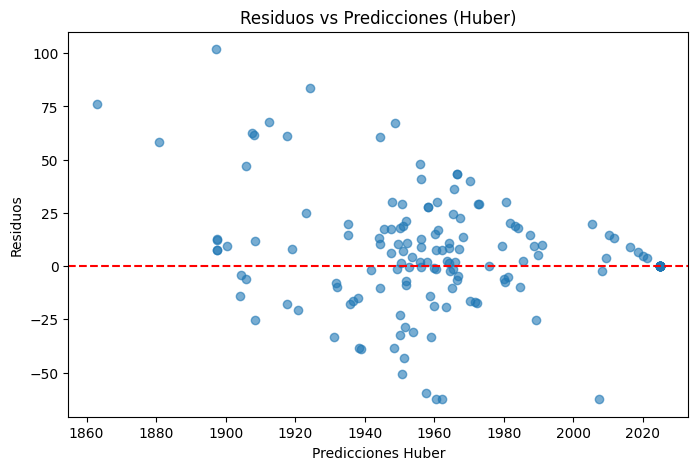

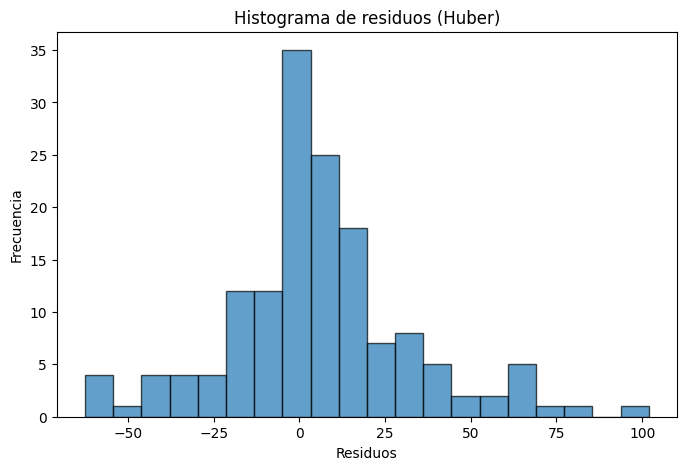

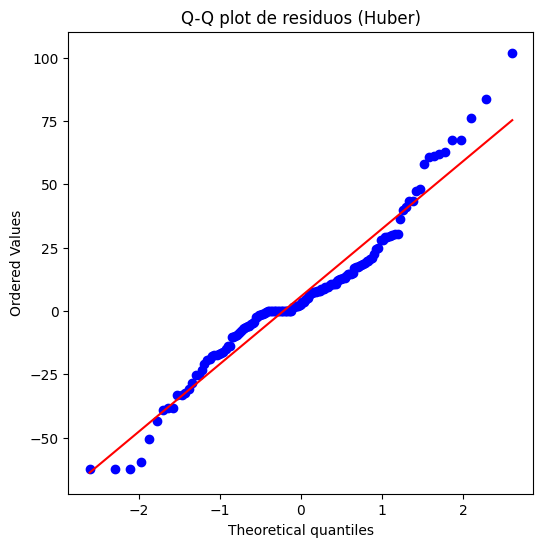

In [ ]:
# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt

# Supongamos que tu dataframe se llama `dataCp2`
data_clean = dataCp2.drop(columns=['url', 'agency','description','floor','exterior', 
                                   'heating','usable_area','consumption_label',
                                   'emissions_label','consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 'Nuevo': 1, 'Buen estado': 0})

# Columnas categóricas con múltiples categorías
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)

# Eliminar filas con NA
data_encoded = data_encoded.dropna()

# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
# 2️⃣ Selección de features con LassoCV
# ---------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

# Coeficientes y features seleccionadas
coef = pd.Series(lasso.coef_, index=X.columns)
selected_features = coef[coef != 0].index.tolist()
print("Features seleccionadas:", selected_features)

# ---------------------------
# 3️⃣ Filtrar X_train/X_test solo con features seleccionadas
# ---------------------------
X_train_sel = X_train_scaled[:, [X.columns.get_loc(f) for f in selected_features]]
X_test_sel  = X_test_scaled[:, [X.columns.get_loc(f) for f in selected_features]]

# ---------------------------
# 4️⃣ Optimización de HuberRegressor con RandomizedSearchCV
# ---------------------------
huber = HuberRegressor(max_iter=1000)

param_grid = {
    'epsilon': np.linspace(1.0, 10.0, 20),   # 20 valores entre 1 y 10
    'alpha': np.logspace(0, 10, 20)        # 100 valores entre 0 y 10
}

grid_search = GridSearchCV(
    huber,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train_sel, y_train)
# Mejor modelo

best_huber = grid_search.best_estimator_   
print("Mejores hiperparámetros:", grid_search.best_params_)

# ---------------------------
# 5️⃣ Predicciones y evaluación
# ---------------------------
y_pred_huber = best_huber.predict(X_test_sel)
y_pred_huber = np.clip(y_pred_huber, min(dataCp2["year"]), max(dataCp2["year"]))

rmse_huber = np.sqrt(mean_squared_error(y_test, y_pred_huber))
r2_huber   = r2_score(y_test, y_pred_huber)
mae_huber  = mean_absolute_error(y_test, y_pred_huber)

print(f"RMSE Huber: {rmse_huber:.2f}")
print(f"R² Huber: {r2_huber:.2f}")
print(f"MAE Huber: {mae_huber:.2f}")

# ---------------------------
# 6️⃣ Análisis de residuos
# ---------------------------
residuals_huber = y_test - y_pred_huber

# a) Residual plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred_huber, residuals_huber, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones Huber")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones (Huber)")
plt.show()

# b) Histograma de residuos
plt.figure(figsize=(8,5))
plt.hist(residuals_huber, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos (Huber)")
plt.show()

# c) Q-Q plot de residuos
plt.figure(figsize=(6,6))
stats.probplot(residuals_huber, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos (Huber)")
plt.show()



AS WE CAN SEE THE POLYNOMIAL REGRESSION GIVES VERY BAD RESULTS

RMSE: 72.77
R²: -2.40
MAE: 44.85


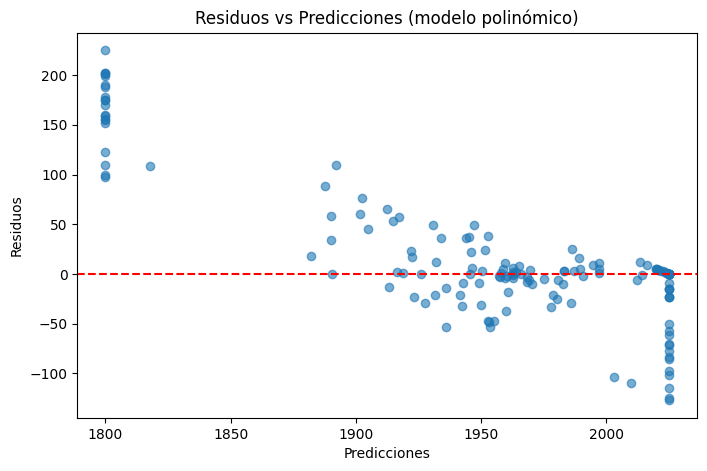

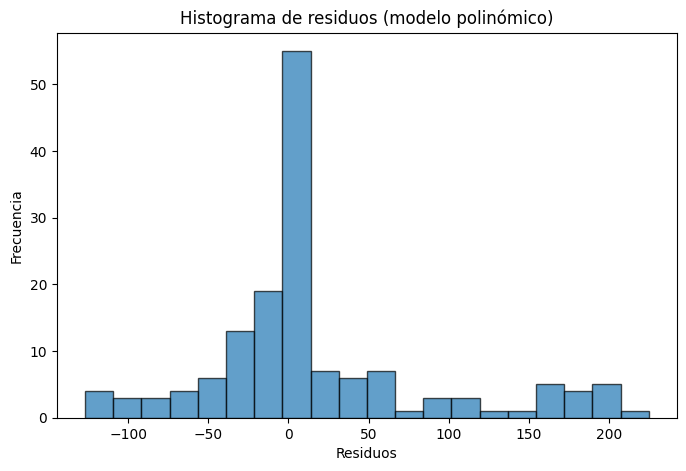

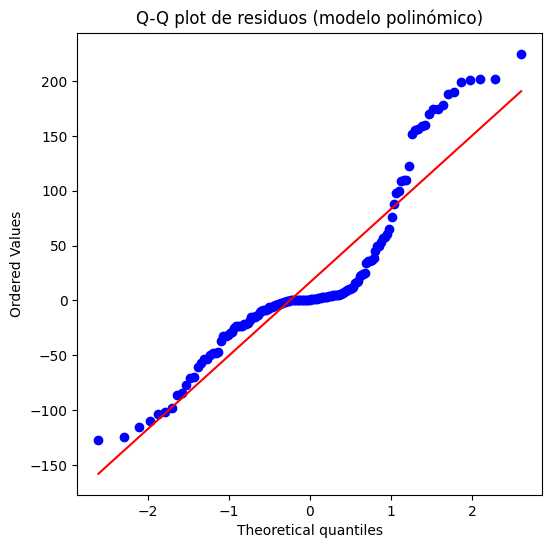

In [ ]:
# ---------------------------
# 🌟 REGRESIÓN POLINÓMICA
# ---------------------------
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
import numpy as np

# ---------------------------
# 1️⃣ Preparar los datos
# ---------------------------
data_clean = dataCp2.drop(columns=['url', 'agency','description','floor','exterior', 
                                   'heating','usable_area','consumption_label','emissions_label',
                                   'consumption_value','emissions_value'])

# Convertir columnas binarias a 0/1
binary_cols = ['elevator', 'garage', 'storage_room', 'balcony', 'new']
for col in binary_cols:
    data_clean[col] = data_clean[col].map({True: 1, False: 0, 'True': 1, 'False': 0, 
                                           'Nuevo': 1, 'Buen estado': 0})

# Columnas categóricas
categorical_cols = ['zone', 'neighborhood', 'condition']
data_encoded = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)

# Eliminar filas con NA
data_encoded = data_encoded.dropna()

# Separar variables dependiente e independiente
X = data_encoded.drop(columns=['year'])
y = data_encoded['year']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 2️⃣ Crear el modelo polinómico
# ---------------------------
# Grado del polinomio (ajústalo según rendimiento)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transformar las features a polinómicas
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Regresión lineal sobre las features polinómicas
model = LinearRegression()
model.fit(X_train_poly, y_train)

# ---------------------------
# 3️⃣ Evaluar el modelo
# ---------------------------
y_pred = model.predict(X_test_poly)

# Limitar las predicciones entre 1800 y 2025
y_pred = np.clip(y_pred, min(dataCp2["year"]), max(dataCp2["year"]))

# Métricas
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# ---------------------------
# 4️⃣ Análisis de residuos
# ---------------------------
residuals = y_test - y_pred

# a) Residual plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones (modelo polinómico)")
plt.show()

# b) Histograma de residuos
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos (modelo polinómico)")
plt.show()

# c) Q-Q plot de residuos
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos (modelo polinómico)")
plt.show()

### Consumption label cleaning

In [ ]:
# PREPARING THE DATA
data_consumption = data.copy()
print(data_consumption.info())
data_consumption.drop(columns=["consumption_value", "emissions_value", "emissions_label", "url", "description"], inplace=True)

data_consumption = data_consumption.dropna(subset=["consumption_label"])

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   url                1230 non-null   object  
 1   price              1230 non-null   float64 
 2   zone               1230 non-null   category
 3   neighborhood       1230 non-null   category
 4   built_area         1230 non-null   float64 
 5   usable_area        1230 non-null   float64 
 6   bedrooms           1230 non-null   int32   
 7   bathrooms          1230 non-null   int32   
 8   floor              1103 non-null   float64 
 9   exterior           1084 non-null   object  
 10  elevator           1230 non-null   bool    
 11  garage             1230 non-null   bool    
 12  storage_room       1230 non-null   bool    
 13  balcony            1230 non-null   bool    
 14  new                1230 non-null   bool    
 15  condition          1230 non-null   object  
 16  year       

In [ ]:
# FIRST SUBSET: drop rows with any null value
data_consumption_subset1 = data_consumption.dropna(axis=0)

X_consumption_1 = data_consumption_subset1.drop(columns=["consumption_label"])
y_consumption_1 = data_consumption_subset1["consumption_label"]

In [ ]:
# SECOND SUBSET:
data_consumption_subset2 = data_consumption.copy()

for col in ["usable_area", "floor", "year"]:
    data_consumption_subset2[col] = data_consumption[col].fillna(data_consumption[col].median())

for col in ["exterior", "heating", "condition"]:
    data_consumption_subset2[col] = data_consumption[col].fillna(data_consumption[col].mode()[0])

X_consumption_2 = data_consumption_subset2.drop(columns=["consumption_label"])
y_consumption_2 = data_consumption_subset2["consumption_label"]

print(X_consumption_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 791 entries, 0 to 1485
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price         791 non-null    float64 
 1   zone          791 non-null    category
 2   neighborhood  791 non-null    category
 3   built_area    791 non-null    float64 
 4   usable_area   791 non-null    float64 
 5   bedrooms      791 non-null    int64   
 6   bathrooms     791 non-null    int64   
 7   floor         791 non-null    float64 
 8   exterior      791 non-null    object  
 9   elevator      791 non-null    bool    
 10  garage        791 non-null    bool    
 11  storage_room  791 non-null    bool    
 12  balcony       791 non-null    bool    
 13  new           791 non-null    bool    
 14  condition     791 non-null    object  
 15  year          791 non-null    float64 
 16  heating       791 non-null    object  
 17  agency        791 non-null    category
dtypes: bool(5), ca

In [ ]:
# IMPLEMENTING THE MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score

cat_cols = ["zone", "neighborhood", "exterior", "condition", "heating", "agency"]

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision',
    'roc_auc': 'roc_auc',
    'mcc': 'matthews_corrcoef'
}

In [ ]:
# FIRST SUBSET
X_consumption_1encoded = df = pd.get_dummies(X_consumption_1, columns=cat_cols, drop_first=True)
y_consumption_1encoded = LabelEncoder().fit_transform(y_consumption_1)

model1 = RandomForestClassifier()

scores = cross_validate(model1, X_consumption_1encoded, y_consumption_1encoded, 
                       cv=5, scoring=scoring, return_train_score=True)

for metric_name, metric_scores in scores.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")


c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\skl

test_accuracy: 0.5993 (+/- 0.0496)
test_f1: nan (+/- nan)
test_recall: nan (+/- nan)
test_precision: nan (+/- nan)
test_roc_auc: nan (+/- nan)
test_mcc: 0.2980 (+/- 0.1151)


c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\metrics\_class

In [ ]:
# SECOND SUBSET
X_consumption_2encoded = df = pd.get_dummies(X_consumption_2, columns=cat_cols, drop_first=True)
y_consumption_2encoded = LabelEncoder().fit_transform(y_consumption_2)

X_train, X_test, y_train, y_test = train_test_split(X_consumption_2encoded, y_consumption_2encoded, test_size=0.2, stratify=y_consumption_2encoded, random_state=42)

model2 = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)

scores = cross_validate(model2, X_consumption_2encoded, y_consumption_2encoded, 
                       cv=5, scoring=scoring, return_train_score=True)

for metric_name, metric_scores in scores.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

NameError: name 'pd' is not defined

###  EXTERIOR 

In [ ]:

data.columns


Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'heating',
       'agency', 'consumption_value', 'consumption_label', 'emissions_value',
       'emissions_label', 'description'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
# Miramos si en la columna de descrippcion esta la palabra exterior (si tiene la palabra terraza o balcon lo incluimos tambien) 

print(data["exterior"].isnull().sum())
condicion_esnula = data["exterior"].isnull()
condicion_contiene_palabra = data["description"].str.contains("exterior|terraza|balcon", case=False, na=False)
data.loc[condicion_contiene_palabra & condicion_esnula, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())

print(data["exterior"].isnull().sum())
condicion_esnula = data["exterior"].isnull()
condicion_contiene_palabra = data["description"].str.contains("interior|sin terraza|sin balcon|luz indirecta", case=False, na=False)
data.loc[condicion_contiene_palabra & condicion_esnula, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())



#A partir de agosto del 22 todas las casas nuevas deben de ser exteriores -> hacemos que a partir del 2023 incluido si es nulo se pone exterior (esto creo que bien)
print(data["exterior"].isnull().sum())
condicion_año = data["year"] >= 2023
data.loc[condicion_esnula & condicion_año, "exterior"] = "exterior"
print(data["exterior"].isnull().sum())


#En este caso no nos ha servido ya que con el de arriba hemos cubieto a la segunda pero lo mantenemos por si en un futuro se actualiza



146
52
52
46
46
46


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
# Importamos el Pipeline de imblearn para incluir el sampler
from imblearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler


# Separar filas con etiqueta y las que hay que predecir
train_val_data = data.dropna(subset=["exterior"]).copy() 
train_val_data["target"] = train_val_data["exterior"].apply(lambda x: 1 if x == "exterior" else 0)

# === 1. INGENIERÍA DE CARACTERÍSTICAS ===
train_val_data["price_per_usable_area"] = train_val_data["price"] / train_val_data["usable_area"]
train_val_data["age"] = 2025 - train_val_data["year"]
train_val_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Definir características
num_features  = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", 
                 "price_per_usable_area", "age"] 
bool_features = ["elevator", "garage", "storage_room", "balcony"]
cat_features  = ["new", "condition", "heating", "consumption_label", "emissions_label"]

features = num_features + bool_features + cat_features

# Convertir booleanos a 1/0
for b in bool_features:
    if b in train_val_data.columns:
        train_val_data[b] = train_val_data[b].map({True:1, False:0, "True":1, "False":0}).fillna(0).astype(int)
        
# Separar features y target
X = train_val_data[features]
y = train_val_data["target"]

# Split train/val estratificado
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y 
)

# === 2. PREPROCESAMIENTO (LGBM + OrdinalEncoder) ===
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combinamos booleanas y categóricas para el OrdinalEncoder
categorical_cols = bool_features + cat_features

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, categorical_cols)
])

# Índices categóricos para LGBM 
categorical_indices = list(range(len(num_features), len(num_features) + len(categorical_cols)))

print(f"Columnas numéricas: {len(num_features)}")
print(f"Columnas categóricas: {len(categorical_cols)}")
print(f"Índices categóricos: {categorical_indices}")


# === 3. PIPELINE con RandomUnderSampler y LGBM ===

lgbm = LGBMClassifier(
    random_state=199, 
    n_jobs=1,
    categorical_feature=categorical_indices 
) 

# Usamos Pipeline 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomUnderSampler(random_state=1)), # Estrategia ganadora
    ("classifier", lgbm)
])

# === 4. GRIDSEARCH  ===
param_grid = {
    'classifier__n_estimators': [100, 200, 400],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [15, 31, 63],
    'classifier__max_depth': [7, 10, -1]
}

min_class_count = y.value_counts().min()
n_splits = 4 if min_class_count >= 4 else max(2, min_class_count)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='balanced_accuracy', 
    n_jobs=-1,
    verbose=2
)

# Entrenar modelo
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best CV Balanced Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# 1. Obtener las probabilidades para la clase 1 (Exterior)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# === 5. OPTIMIZACIÓN DE UMBRAL (Enfocada en Clase 0) ===
thresholds = np.linspace(0.01, 0.99, 100)
best_f1_minority = 0 
best_threshold = 0.5

for t in thresholds:
    y_pred_t = (y_val_proba >= t).astype(int)
    # Optimizamos para el F1-score de la clase 0
    f1_minority = f1_score(y_val, y_pred_t, pos_label=0) 
    
    if f1_minority > best_f1_minority:
        best_f1_minority = f1_minority
        best_threshold = t

print(f"\nMejor umbral encontrado en validación: {best_threshold:.4f}")
print(f"Mejor F1-Score (Clase 0) en validación: {best_f1_minority:.4f}")

# 2. Aplicar el umbral ÓPTIMO
y_val_pred_adjusted = (y_val_proba >= best_threshold).astype(int)

# === 6. REPORTE DE MÉTRICAS ===
print(f"\n=== Resultados de Validación (Umbral Óptimo: {best_threshold:.4f}) ===")
print(classification_report(y_val, y_val_pred_adjusted))
print("Matriz de Confusión Ajustada:\n", confusion_matrix(y_val, y_val_pred_adjusted))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred_adjusted):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba):.4f}")


Columnas numéricas: 8
Columnas categóricas: 9
Índices categóricos: [8, 9, 10, 11, 12, 13, 14, 15, 16]
Fitting 4 folds for each of 54 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 102, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\gonzalo.iglesias\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\gonzalo.iglesias\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd 

# --- 1. Definición del Umbral Óptimo ---
# Estos son los parámetros de la ejecución 
threshold = 0.2179 

# --- 2. Preparación de Datos (SOLO para predicción) ---

# Encontrar las filas que necesitan predicción
predict_data_indices = data[data["exterior"].isna()].index

# Crear una copia para trabajar SÓLO con los datos a predecir
predict_data = data.loc[predict_data_indices].copy()


if not predict_data.empty:
    # --- 2b. Ingeniería y Definición de Características ---
    # ¡IMPORTANTE! Aplicar la MISMA ingeniería de características que en el entrenamiento
    
    # --- Definir listas de features (para asegurar el orden y selección) ---
    num_features  = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", 
                     "price_per_usable_area", "age"] 
    bool_features = ["elevator", "garage", "storage_room", "balcony"]
    cat_features  = ["new", "condition", "heating", "consumption_label", "emissions_label"]
    
    # Lista total de features que el modelo espera
    features = num_features + bool_features + cat_features

    # Aplicar ingeniería de características
    predict_data["price_per_usable_area"] = predict_data["price"] / predict_data["usable_area"]
    predict_data["age"] = 2025 - predict_data["year"]
    
    # Limpiar infinitos generados por la división
    predict_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Convertir booleanos a 1/0
    for b in bool_features:
        if b in predict_data.columns:
            predict_data[b] = predict_data[b].map({True:1, False:0, "True":1, "False":0}).fillna(0).astype(int)

    # Seleccionar solo las columnas que el modelo necesita, en el orden correcto
    X_predict = predict_data[features]
    
    print(f"Realizando predicciones en {len(X_predict)} filas con exterior nulo...")
    
    # --- 3. Predicción (Usando 'best_model' existente) ---
    # NO se redefine el pipeline, NO se usa .fit()
    
    # Obtener probabilidades para la clase 1 (Exterior)
    # 'best_model' es el pipeline completo (preprocesador + sampler + clasificador)
    # El preprocesador dentro de best_model manejará la imputación y el escalado
    preds_proba = best_model.predict_proba(X_predict)[:, 1]
    
    # Aplicar el umbral óptimo
    preds_adjusted = (preds_proba >= threshold).astype(int)

    # Convertir 1/0 a 'exterior'/'interior'
    predicted_exterior_labels = np.where(preds_adjusted == 1, "exterior", "interior")
    
    # --- 4. Inserción de Predicciones en la Tabla Original 'data' ---
    
    # Usar .loc para asignar los valores de vuelta al DataFrame original
    data.loc[predict_data.index, "exterior"] = predicted_exterior_labels
    
    print("Predicciones completadas e insertadas en la tabla 'data'.")
    print(f"Valores predichos (Count): {len(predicted_exterior_labels)}")
    print(f"Conteo de predicciones: {pd.Series(predicted_exterior_labels).value_counts().to_string()}")

    print("\nVerificación de la tabla 'data' (Filas que antes eran NaN):")
    print(data.loc[predict_data.index, ["url", "exterior"]])

else:
    print("No hay filas con valores nulos en 'exterior' para predecir.")

Realizando predicciones en 46 filas con exterior nulo...
Predicciones completadas e insertadas en la tabla 'data'.
Valores predichos (Count): 46
Conteo de predicciones: exterior    31
interior    15

Verificación de la tabla 'data' (Filas que antes eran NaN):
                                                url  exterior
10    https://www.idealista.com/inmueble/108574469/  exterior
82    https://www.idealista.com/inmueble/107910726/  exterior
83    https://www.idealista.com/inmueble/108520857/  exterior
85    https://www.idealista.com/inmueble/108492917/  exterior
118   https://www.idealista.com/inmueble/105499678/  exterior
133   https://www.idealista.com/inmueble/108180593/  interior
165   https://www.idealista.com/inmueble/109093131/  exterior
227   https://www.idealista.com/inmueble/105802571/  exterior
229   https://www.idealista.com/inmueble/108518410/  exterior
254   https://www.idealista.com/inmueble/109004365/  exterior
258    https://www.idealista.com/inmueble/97461275/  exter

C:\Users\gonzalo.iglesias\AppData\Local\Temp\ipykernel_2136\3471454562.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predict_data.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\gonzalo.iglesias\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Floor:

In [ ]:
print(data.columns)
dataPrueba =data.copy()
print(dataPrueba["floor"].isnull().sum())
#print(dataPrueba[dataPrueba["floor"].isnull()][["floor","url"]])

key_words = {# revisar si entreplanta la contamos como 0
    'sotano': -2, 'semisótano': -2, 'semisotano': -2,'sótano': -2,
    'casa': -1, 'chalet': -1, 'adosado': -1,
    'bajo': 0, 'planta baja': 0,'entreplanta': 0,'piso 0': 0,'planta 0': 0,
    'primera planta': 1, 'primer piso': 1, 'piso 1': 1,'planta 1': 1,
    'segunda planta': 2, 'segundo piso': 2,'Piso 2': 2,'planta 2': 2,
    'tercera planta': 3, 'tercer piso': 3,'piso 3': 3,'planta 3': 3,
    'cuarta planta': 4, 'cuarto piso': 4,'piso 4': 4,'planta 4': 4,
    'quinta planta': 5, 'quinto piso': 5,'piso 5': 5,'planta 5': 5,
    'sexta planta': 6, 'sexto piso': 6,'piso 6': 6,'planta 6': 6,
    'séptima planta': 7, 'séptimo piso': 7,'piso 7': 7,'planta 7': 7,
    'octava planta': 8, 'octavo piso': 8,'piso 8': 8,'planta 8': 8,
    'novena planta': 9, 'noveno piso': 9,'piso 9': 9,'planta 9': 9,
    'décima planta': 10, 'décimo piso': 10,'piso 10': 10,'planta 10': 10
}

for index, row in dataPrueba[dataPrueba["floor"].isnull()].iterrows():
    if any(kw in dataPrueba.loc[index, 'description'].lower() for kw in key_words.keys()):
        for kw, floor_value in key_words.items():
            if kw in dataPrueba.loc[index, 'description'].lower():
                dataPrueba.loc[index, 'floor'] = floor_value
                print(f"encontramos {kw}")
                print(dataPrueba.loc[index, 'url'])
                break


print(dataPrueba["floor"].isnull().sum())
#print(dataPrueba[dataPrueba["floor"].isnull()][["floor","url"]])

#hecho a mano

manual_floors = {
    10: 0,    14: np.nan,    15: 6,    16: 1,
    36: 2,    37: 2,    38: 1,    39: 4,
    56: 2,    59: 7,    60: 7,    66: 6,
    83: 0,    84: np.nan,    196: np.nan,    214: 0,
    227: np.nan,    254: -1,    258: -1,    261: np.nan,
    266: np.nan,    267: np.nan,    268: 0,    316: 0,
    324: 0,    352: np.nan,    368: np.nan,    393: 0,
    398: 0,    452: np.nan,    466: np.nan,    478: np.nan,
    659: 0,    686: np.nan,    738: 0,    742: 0,
    743: 0,    752: 0,    768: 0,    804: 0,        
    950: 1,    951: 14,    953: np.nan,    976: 13,
    977: 20,    978: 13,    992: np.nan,    1001: 0,
    1016: 0,    1030: 0,    1031: 0,    1083: np.nan,
    1090: 0,    1093: 0,    1101: np.nan,    1113: 4,
    1114: 2,    1115: 1,    1116: 2,    1117: 1,
    1118: 4,    1119: 2,    1120: 5,    1121: 5,
    1122: 2,    1123: 2,    1124: 7,    1125: 4,
    1153: np.nan,    1158: 0,    1202: 0,    1203: np.nan,
    1213: np.nan,    1214: np.nan,    1233: 0,    1314: 0,
    1342: np.nan,    1355: np.nan,    1385: np.nan,    1404: 0,
    1414: np.nan,    1431: np.nan,    1433: np.nan,    1438: np.nan,
    1486: 0
}

for idx, val in manual_floors.items():
    dataPrueba.loc[idx, 'floor'] = val


print(dataPrueba["floor"].isnull().sum())


Index(['url', 'price', 'zone', 'neighborhood', 'built_area', 'usable_area',
       'bedrooms', 'bathrooms', 'floor', 'exterior', 'elevator', 'garage',
       'storage_room', 'balcony', 'new', 'condition', 'year', 'heating',
       'agency', 'consumption_value', 'consumption_label', 'emissions_value',
       'emissions_label', 'description'],
      dtype='object')
127
encontramos piso 3
https://www.idealista.com/inmueble/109237730/
encontramos casa
https://www.idealista.com/inmueble/108746339/
encontramos casa
https://www.idealista.com/inmueble/108396564/
encontramos casa
https://www.idealista.com/inmueble/107910726/
encontramos casa
https://www.idealista.com/inmueble/108492917/
encontramos entreplanta
https://www.idealista.com/inmueble/108519774/
encontramos chalet
https://www.idealista.com/inmueble/83189354/
encontramos casa
https://www.idealista.com/inmueble/107023759/
encontramos chalet
https://www.idealista.com/inmueble/108421719/
encontramos chalet
https://www.idealista.com/inmueb

###  Consumption/emision values: (Xabi)

seeing that there is a lot of information missing in the values, we are going to do a study of the values ​​we have, to see in what ranges the labels are in each house in order to assign a label to each one.

In [ ]:
print(data['emissions_label'].isnull().sum())
print(data['emissions_value'].isnull().sum())


dataWithValues = data['emissions_label'].notnull() & data['emissions_value'].notnull()

print(data[dataWithValues]["emissions_label"].value_counts())

468
670
emissions_label
E    339
F     90
G     71
D     41
C     10
A      8
B      1
Name: count, dtype: int64


### Emission Label

**Estrategias:**
1. **Eliminar nulos** - Solo filas completas (sin missing values)

**Métricas de evaluación:**
- Accuracy, F1-weighted, Balanced Accuracy, Precision-weighted, Recall-weighted
- Todas usando **Cross-Validation (StratifiedKFold con 5 folds)**

**Modelos probados:**
- Random Forest (varios hiperparámetros)
- Logistic Regression
- Naive Bayes
- SMV

In [30]:
data.info()

# Miramos cuales son las 2 entradas que tiene floor y no tienen price
print(data[data["price"].isnull()][["url","floor","price"]])

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1489
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   url                1230 non-null   object  
 1   price              1230 non-null   float64 
 2   zone               1230 non-null   category
 3   neighborhood       1230 non-null   category
 4   built_area         1230 non-null   float64 
 5   usable_area        1230 non-null   float64 
 6   bedrooms           1230 non-null   int64   
 7   bathrooms          1230 non-null   int64   
 8   floor              1103 non-null   float64 
 9   exterior           1084 non-null   object  
 10  elevator           1230 non-null   bool    
 11  garage             1230 non-null   bool    
 12  storage_room       1230 non-null   bool    
 13  balcony            1230 non-null   bool    
 14  new                1230 non-null   bool    
 15  condition          1230 non-null   object  
 16  year       

In [31]:
# PREPARING THE DATA
data_consumption = data.copy()

data_consumption.drop(columns=["consumption_value", "emissions_value", "emissions_label", "url", "description", "heating"], inplace=True)
print(data_consumption.info())

data_consumption = data_consumption.dropna(subset=["consumption_label"])
print(data_consumption.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1489
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              1230 non-null   float64 
 1   zone               1230 non-null   category
 2   neighborhood       1230 non-null   category
 3   built_area         1230 non-null   float64 
 4   usable_area        1230 non-null   float64 
 5   bedrooms           1230 non-null   int64   
 6   bathrooms          1230 non-null   int64   
 7   floor              1103 non-null   float64 
 8   exterior           1084 non-null   object  
 9   elevator           1230 non-null   bool    
 10  garage             1230 non-null   bool    
 11  storage_room       1230 non-null   bool    
 12  balcony            1230 non-null   bool    
 13  new                1230 non-null   bool    
 14  condition          1230 non-null   object  
 15  year               751 non-null    float64 
 16  agency     

In [32]:
# Divide the data
X_consumption_1 = data_consumption.drop(columns=["consumption_label"])
y_consumption_1 = data_consumption["consumption_label"]

In [33]:
# IMPLEMENTING THE MODEL
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

cat_cols = ["zone", "neighborhood", "exterior", "condition", "agency"]

# Métricas para evaluación (ajustadas para clasificación multiclase)
scoring = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1',
    'matthews': "matthews_corrcoef",
    'balanced_accuracy': 'balanced_accuracy'
}

# Usar StratifiedKFold para mantener la distribución de clases
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
# ESTRATEGIA 1:
print("="*80)
print("ESTRATEGIA 1: Eliminar todas las filas con valores nulos")
print("="*80)

X_consumption_1encoded = pd.get_dummies(X_consumption_1, columns=cat_cols, drop_first=True)
y_consumption_1encoded = LabelEncoder().fit_transform(y_consumption_1)

print(f"\nNúmero de muestras: {len(X_consumption_1encoded)}")
print(f"Número de features: {X_consumption_1encoded.shape[1]}")
print(f"Distribución de clases: {np.bincount(y_consumption_1encoded)}")

# Probar múltiples modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Naive Bayes': GaussianNB(),
#    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
#    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_subset1 = {}
for name, model in models.items():
    print(f"\n{name}:")
    scores = cross_validate(model, X_consumption_1encoded, y_consumption_1encoded, 
                           cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    results_subset1[name] = {}
    for metric_name, metric_scores in scores.items():
        if metric_name.startswith('test_'):
            metric = metric_name.replace('test_', '')
            results_subset1[name][metric] = (metric_scores.mean(), metric_scores.std())
            print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 1: Eliminar todas las filas con valores nulos

Número de muestras: 1230
Número de features: 366
Distribución de clases: [147   9  18  60 682 123 191]

Random Forest:
  accuracy: 0.7659 (+/- 0.0128)
  recall_weighted: 0.7659 (+/- 0.0128)
  precision_weighted: 0.7705 (+/- 0.0340)
  f1_weighted: nan (+/- nan)
  matthews: 0.6145 (+/- 0.0265)
  balanced_accuracy: 0.5112 (+/- 0.0623)

Random Forest (tuned):
  accuracy: 0.7293 (+/- 0.0088)
  recall_weighted: 0.7293 (+/- 0.0088)
  precision_weighted: 0.7231 (+/- 0.0369)
  f1_weighted: nan (+/- nan)
  matthews: 0.5503 (+/- 0.0167)
  balanced_accuracy: 0.3947 (+/- 0.0377)

Logistic Regression:


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1247, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py", line 1105, in check_array
    _assert_all_finite(
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\iker\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
# DIAGNÓSTICO: Análisis de distribución de clases
print("="*80)
print("DIAGNÓSTICO: Distribución de consumption_label")
print("="*80)

# Distribución en el dataset original
print("\nDistribución en datos de entrenamiento:")
class_dist = pd.Series(y_consumption_1).value_counts().sort_index()
print(class_dist)
print(f"\nPorcentajes:")
print((class_dist / len(y_consumption_1) * 100).round(2))



DIAGNÓSTICO: Distribución de consumption_label

Distribución en datos de entrenamiento:
consumption_label
A     98
B      9
C     16
D     58
E    370
F    109
G    131
Name: count, dtype: int64

Porcentajes:
consumption_label
A    12.39
B     1.14
C     2.02
D     7.33
E    46.78
F    13.78
G    16.56
Name: count, dtype: float64


In [ ]:
# ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo
print("="*80)
print("ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo")
print("="*80)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Usar el dataset de la Estrategia 1
print(f"\nDistribución ANTES de SMOTE:")
unique, counts = np.unique(y_consumption_1encoded, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Clase {u}: {c} muestras ({c/len(y_consumption_1encoded)*100:.1f}%)")

# Crear pipelines con SMOTE
smote_models = {
    'RF + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1))
    ]),
    'RF + SMOTE + Class Weight': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, 
                                             class_weight='balanced', random_state=42, n_jobs=-1))
    ]),
    'SVM + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', SVC(kernel='rbf', random_state=42, probability=True))
    ]),
    'NB + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', GaussianNB())
    ])
}

results_subset4 = {}
for name, model in smote_models.items():
    print(f"\n{name}:")
    scores = cross_validate(model, X_consumption_1encoded, y_consumption_1encoded, 
                           cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
    results_subset4[name] = {}
    for metric_name, metric_scores in scores.items():
        if metric_name.startswith('test_'):
            metric = metric_name.replace('test_', '')
            results_subset4[name][metric] = (metric_scores.mean(), metric_scores.std())
            print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 4: SMOTE + Class Weighting para desbalanceo

Distribución ANTES de SMOTE:
  Clase 0: 98 muestras (12.4%)
  Clase 1: 9 muestras (1.1%)
  Clase 2: 16 muestras (2.0%)
  Clase 3: 58 muestras (7.3%)
  Clase 4: 370 muestras (46.8%)
  Clase 5: 109 muestras (13.8%)
  Clase 6: 131 muestras (16.6%)

RF + SMOTE:
  accuracy: 0.6232 (+/- 0.0289)
  recall_weighted: 0.6232 (+/- 0.0289)
  precision_weighted: 0.6202 (+/- 0.0257)
  f1_weighted: nan (+/- nan)
  matthews: 0.4610 (+/- 0.0420)
  balanced_accuracy: 0.4821 (+/- 0.0558)

RF + SMOTE + Class Weight:
  accuracy: 0.6232 (+/- 0.0289)
  recall_weighted: 0.6232 (+/- 0.0289)
  precision_weighted: 0.6202 (+/- 0.0257)
  f1_weighted: nan (+/- nan)
  matthews: 0.4610 (+/- 0.0420)
  balanced_accuracy: 0.4821 (+/- 0.0558)

SVM + SMOTE:
  accuracy: 0.1947 (+/- 0.0271)
  recall_weighted: 0.1947 (+/- 0.0271)
  precision_weighted: 0.4182 (+/- 0.1133)
  f1_weighted: nan (+/- nan)
  matthews: 0.1147 (+/- 0.0355)
  balanced_accuracy: 0.2100 (+/- 0.0494)

ANÁLISIS DE CLASES PROBLEMÁTICAS
Generando predicciones con cross-validation...

Matriz de confusión:
[[ 82   0   0   1  14   0   1]
 [  1   5   0   0   3   0   0]
 [  0   0   0   0  14   0   2]
 [  0   0   0   4  52   1   1]
 [  0   0   0   0 351   4  15]
 [  0   0   0   0  92   9   8]
 [  0   0   0   0  82   1  48]]


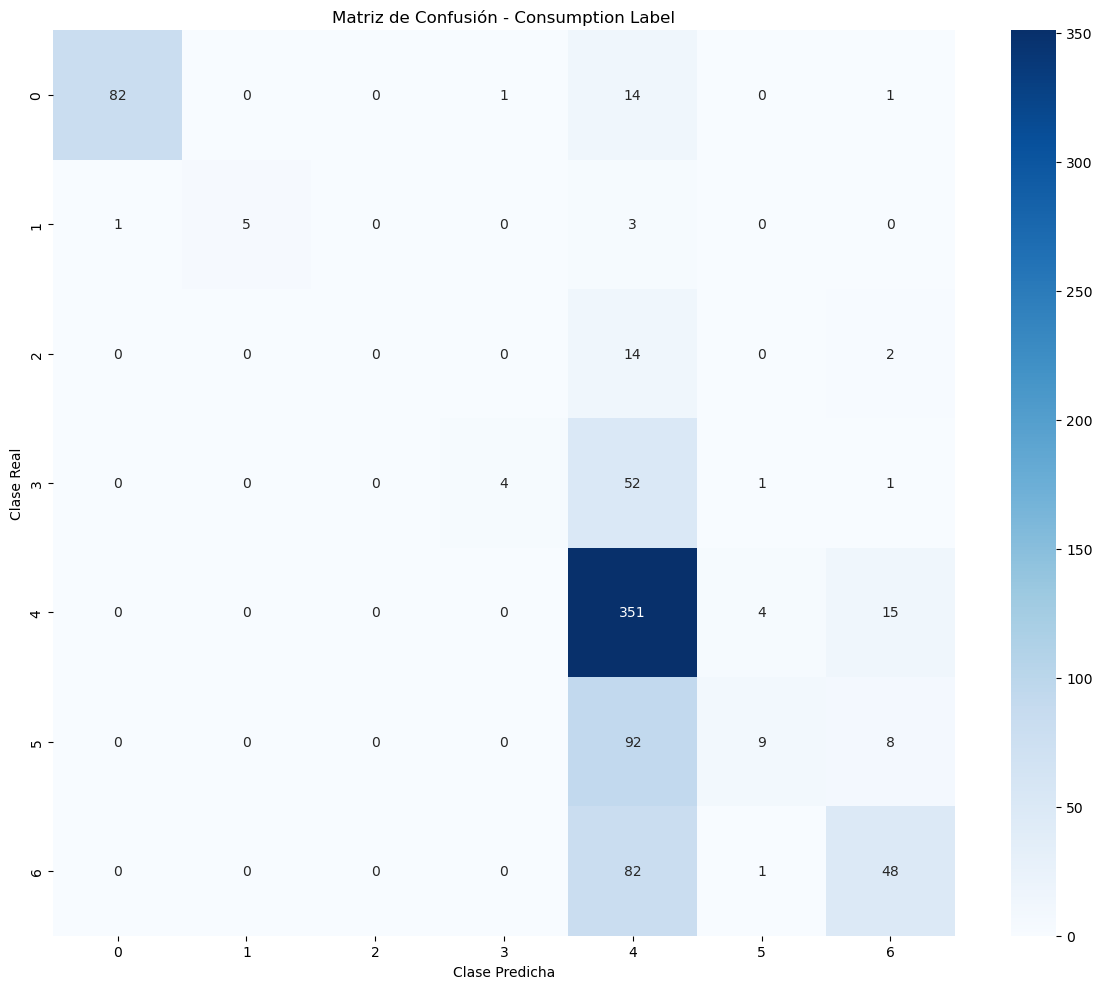


Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.99      0.84      0.91        98
           B       1.00      0.56      0.71         9
           C       0.00      0.00      0.00        16
           D       0.80      0.07      0.13        58
           E       0.58      0.95      0.72       370
           F       0.60      0.08      0.15       109
           G       0.64      0.37      0.47       131

    accuracy                           0.63       791
   macro avg       0.66      0.41      0.44       791
weighted avg       0.65      0.63      0.56       791




In [ ]:
# Análisis de clases problemáticas
print("="*80)
print("ANÁLISIS DE CLASES PROBLEMÁTICAS")
print("="*80)

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenar el mejor modelo actual y obtener predicciones
best_current_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)

print("Generando predicciones con cross-validation...")
# Obtener predicciones con cross-validation
y_pred_cv = cross_val_predict(best_current_model, X_consumption_1encoded, y_consumption_1encoded, 
                               cv=cv_strategy, n_jobs=-1)

# Obtener las etiquetas originales
le_temp = LabelEncoder()
y_temp = le_temp.fit_transform(y_consumption_1)

# Matriz de confusión
print("\nMatriz de confusión:")
cm = confusion_matrix(y_consumption_1encoded, y_pred_cv)
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Consumption Label')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_consumption_1encoded, y_pred_cv, 
                           target_names=le_temp.classes_, zero_division=0))

print("\n" + "="*80)

In [ ]:
# El modelo que mejor ha funcionado ha sido el de randomForest ('Random Forest': RandomForestClassifier(n_estimators=100, random_state=42))
# Queremos mejorar el modelo con las clases que mas problemas dan (clases C, D, F, G)

### Estrategias de mejora para clases problemáticas (C, D, F, G)

In [29]:
# ESTRATEGIA 5: Undersampling de la clase E (mayoritaria)
print("="*80)
print("ESTRATEGIA 5: Undersampling de la clase E")
print("="*80)

from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Verificar la distribución actual
print("\nDistribución ANTES de undersampling:")
unique, counts = np.unique(y_consumption_1encoded, return_counts=True)
for u, c in zip(unique, counts):
    label = le_temp.classes_[u]
    print(f"  Clase {label} ({u}): {c} muestras ({c/len(y_consumption_1encoded)*100:.1f}%)")

# Configurar undersampling para balancear la clase E con las demás
# Vamos a reducir E para que no supere cierto factor respecto a la segunda clase
class_counts = dict(zip(unique, counts))
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Calcular target: que la clase mayoritaria tenga como máximo 1.5x la segunda clase
# PERO sin superar el número de muestras originales
target_E_samples = min(
    sorted_counts[0][1],  # No superar el número original
    int(sorted_counts[1][1] * 1.5)  # 1.5 veces la segunda clase más grande
)

# Define la estrategia SOLAMENTE para la clase mayoritaria que quieres reducir
# sorted_counts[0][0] es el label de la clase 'E' (la mayoría)
sampling_strategy = {sorted_counts[0][0]: target_E_samples}


print(f"\nObjetivo de muestras para clase mayoritaria (clase {le_temp.classes_[sorted_counts[0][0]]}): {target_E_samples}")
print(f"Original: {sorted_counts[0][1]} muestras")

# Crear pipeline con undersampling
undersampling_model = ImbPipeline([
        ('undersampler', RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1))
    ])


results_subset5 = {}
print(f"\n{'RF + Undersampling'}:")
score = cross_validate(undersampling_model, X_consumption_1encoded, y_consumption_1encoded, 
                        cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
    
results_subset5[name] = {}
for metric_name, metric_scores in scores.items():
    if metric_name.startswith('test_'):
        metric = metric_name.replace('test_', '')
        results_subset5[name][metric] = (metric_scores.mean(), metric_scores.std())
        print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")

print("\n" + "="*80)

ESTRATEGIA 5: Undersampling de la clase E

Distribución ANTES de undersampling:


NameError: name 'y_consumption_1encoded' is not defined

In [ ]:
# Hemos intentado varias cosas para mejorar el modelo de clasificación de consumption_label, pero no hemos conseguido mejorar el rendimiento respecto al modelo base de RandomForest.
# Por tanto, nos quedamos con el modelo base de RandomForest como el mejor modelo para predecir consumption_label. 
# Usamos este modelo para predecir los valores faltantes en la tabla original 'data'. RandomForestClassifier(n_estimators=100, random_state=42)
# models['Random Forest']

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print(f"Valores nulos en 'emissions_label' ANTES: {data['emissions_label'].isna().sum()}")

# --- 1. Definir Features ---
# Seleccionamos las columnas que servirán para predecir
# Excluimos 'emissions_value', 'consumption_value', 'consumption_label' 
# ya que están relacionadas con el objetivo o también tienen muchos nulos.
num_features = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "year"]

# Incluimos las booleanas como categóricas para el OneHotEncoder
cat_features = ["zone", "neighborhood", "exterior", "new", "condition", "agency", 
                "elevator", "garage", "storage_room", "balcony"]

# Combinar todas las features
features_all = num_features + cat_features

# --- 2. Separar Datos ---
# Creamos un set de entrenamiento con las filas donde 'emissions_label' SÍ se conoce
data_to_train = data[data['emissions_label'].notna()].copy()
# Creamos un set de predicción con las filas donde 'emissions_label' es NaN
data_to_predict = data[data['emissions_label'].isna()].copy()

print(f"Filas para entrenar: {len(data_to_train)}")
print(f"Filas para predecir (NaNs): {len(data_to_predict)}")

# --- 3. Preparar X e y ---
if len(data_to_predict) > 0 and len(data_to_train) > 0:
    # X_train e y_train (para entrenar el modelo)
    X_train = data_to_train[features_all]
    y_train = data_to_train['emissions_label']
    
    # X_predict (solo las features de las filas con NaNs)
    X_predict = data_to_predict[features_all]

    # --- 4. Crear Pipeline de Preprocesamiento y Modelo ---
    
    # Transformador para features numéricas: imputar mediana y escalar
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Transformador para features categóricas: imputar más frecuente y One-Hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    # ColumnTransformer para aplicar los transformadores correctos a cada columna
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # Modelo de RandomForestClassifier (como el de tu celda)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Crear el pipeline final: Preprocesamiento -> Clasificador
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    # --- 5. Entrenar el Modelo ---
    print("\nEntrenando el modelo RandomForestClassifier...")
    pipeline.fit(X_train, y_train)

    # --- 6. Predecir los Valores Faltantes ---
    print("Realizando predicciones para 'emissions_label'...")
    predicted_labels = pipeline.predict(X_predict)

    # --- 7. Rellenar los NaNs en el DataFrame 'data' ---
    # Usamos .loc para asignar los valores predichos SOLO a las filas donde era NaN
    data.loc[data['emissions_label'].isna(), 'emissions_label'] = predicted_labels

    print("¡Valores NaN en 'emissions_label' rellenados!")
    print(f"Valores nulos en 'emissions_label' AHORA: {data['emissions_label'].isna().sum()}")

else:
    print("No hay suficientes datos para entrenar o no hay valores para predecir.")

# Mostrar el estado de la columna 'emissions_label'
print("\nConteo de valores en 'emissions_label' después de rellenar:")
print(data['emissions_label'].value_counts(dropna=False))

Valores nulos en 'emissions_label' ANTES: 468
Filas para entrenar: 762
Filas para predecir (NaNs): 468

Entrenando el modelo RandomForestClassifier...
Realizando predicciones para 'emissions_label'...
¡Valores NaN en 'emissions_label' rellenados!
Valores nulos en 'emissions_label' AHORA: 0

Conteo de valores en 'emissions_label' después de rellenar:
emissions_label
E    755
A    151
F    130
G    111
D     54
C     20
B      9
Name: count, dtype: int64


### Consumption Label

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- 1. Definir Features (basado en tu celda [34]) ---
# Excluimos las otras columnas de emisiones/consumo para evitar fuga de datos
num_features = ["price", "built_area", "usable_area", "bedrooms", "bathrooms", "floor", "year"]

cat_features = ["zone", "neighborhood", "exterior", "new", "condition", "agency", 
                "elevator", "garage", "storage_room", "balcony"]

features_all = num_features + cat_features

# --- 2. Separar Datos ---
# Filas para entrenar (donde 'consumption_label' se conoce)
data_to_train = data[data['consumption_label'].notna()].copy()
# Filas para predecir (donde 'consumption_label' es NaN)
data_to_predict = data[data['consumption_label'].isna()].copy()

print(f"Valores nulos en 'consumption_label' ANTES: {data['consumption_label'].isna().sum()}")
print(f"Filas para entrenar: {len(data_to_train)}")
print(f"Filas para predecir (NaNs): {len(data_to_predict)}")

if len(data_to_predict) > 0 and len(data_to_train) > 0:
    # --- 3. Preparar X e y ---
    X_train = data_to_train[features_all]
    y_train = data_to_train['consumption_label']
    
    # Solo las features de las filas con NaNs
    X_predict = data_to_predict[features_all]

    # --- 4. Crear Pipeline de Preprocesamiento y Modelo ---
    
    # Transformador para features numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Transformador para features categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    # ColumnTransformer para aplicar los transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_features),
            ('cat', categorical_transformer, cat_features)
        ])

    # El modelo que seleccionaste
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Crear el pipeline final
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_classifier)
    ])

    # --- 5. Entrenar el Modelo ---
    print("\nEntrenando el modelo RandomForestClassifier...")
    pipeline.fit(X_train, y_train)

    # --- 6. Predecir los Valores Faltantes ---
    print("Realizando predicciones para 'consumption_label'...")
    predicted_labels = pipeline.predict(X_predict)

    # --- 7. Rellenar los NaNs en el DataFrame 'data' ---
    data.loc[data['consumption_label'].isna(), 'consumption_label'] = predicted_labels

    print("¡Valores NaN en 'consumption_label' rellenados!")
    print(f"Valores nulos en 'consumption_label' AHORA: {data['consumption_label'].isna().sum()}")

else:
    print("No hay suficientes datos para entrenar o no hay valores para predecir.")

# Mostrar el estado de la columna
print("\nConteo de valores en 'consumption_label' después de rellenar:")
print(data['consumption_label'].value_counts(dropna=False))

Valores nulos en 'consumption_label' ANTES: 439
Filas para entrenar: 791
Filas para predecir (NaNs): 439

Entrenando el modelo RandomForestClassifier...
Realizando predicciones para 'consumption_label'...
¡Valores NaN en 'consumption_label' rellenados!
Valores nulos en 'consumption_label' AHORA: 0

Conteo de valores en 'consumption_label' después de rellenar:
consumption_label
E    682
G    191
A    147
F    123
D     60
C     18
B      9
Name: count, dtype: int64


### FINAL DECISIONS

In [ ]:
# Eliminamos columna heating
data.drop(columns=["heating"], inplace=True)
# Eliminamos columnas consumption_value y emissions_value
data.drop(columns=["consumption_value", "emissions_value"], inplace=True)

## STORE

In [27]:
# We store the data in a csv file
data.to_csv("../data/cleaned/data_final.csv", index=False)